In [1]:
# Core
import numpy as np
import pandas as pd

# Tensorflow / ML
import tensorflow as tf

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Utility
import os
import time

In [2]:
# Set visibible GPU
gpu_num: int = 3
os.environ['CUDA_VISIBLE_DEVICES']=f'{gpu_num}'

In [3]:
# Configure TF GPU growth
import kepler_sieve
from tf_utils import gpu_grow_memory
gpu_grow_memory(verbose=True)

Found 1 GPUs.  Setting memory growth = True.


In [4]:
# MSE Imports
from asteroid_element import load_ast_elt
from candidate_element import asteroid_elts, perturb_elts, random_elts, elts_add_mixture_params, elts_add_H
from ztf_ast import load_ztf_nearest_ast, calc_hit_freq
from ztf_element import load_ztf_batch, make_ztf_batch, ztf_score_by_elt, ztf_elt_summary
from asteroid_model import AsteroidPosition, AsteroidDirection, make_model_ast_pos
from asteroid_search_layers import CandidateElements, MixtureParameters, TrajectoryScore
from asteroid_search_model import AsteroidSearchModel
from asteroid_search_report import traj_diff
from nearest_asteroid import nearest_ast_elt_cart, nearest_ast_elt_cov, elt_q_norm
from element_eda import score_by_elt
from asteroid_dataframe import calc_ast_data, spline_ast_vec_df
from astro_utils import deg2dist, dist2deg, dist2sec

In [5]:
# Aliases
keras = tf.keras

# Constants
dtype = tf.float32
dtype_np = np.float32
space_dims = 3

In [6]:
# Set plot style variables
mpl.rcParams['figure.figsize'] = [16.0, 10.0]
mpl.rcParams['font.size'] = 16

## Load ZTF Data and Batch of Orbital Elements

In [7]:
# Load orbital elements for known asteroids
ast_elt = load_ast_elt()

# Number of asteroids
N_ast = ast_elt.shape[0]

In [8]:
# Load ztf nearest asteroid data
ztf_ast = load_ztf_nearest_ast()

In [9]:
# Asteroid numbers and hit counts
ast_num, hit_count = calc_hit_freq(ztf=ztf_ast, thresh_sec=2.0)

# Sort the hit counts in descending order and find the top batch_size
idx = np.argsort(hit_count)[::-1]

# Extract the asteroid number and hit count for this batch
ast_num_best = ast_num[idx]
hit_count_best = hit_count[idx]

In [10]:
# Parameters to build elements batch
batch_size = 64

# Batch of unperturbed elements
elts_ast = asteroid_elts(ast_nums=ast_num_best[0:batch_size])

In [11]:
# # Review unperturbed elements
# elts_ast

In [12]:
# Inputs to perturb elements: small
sigma_a = 0.01
sigma_e = 0.0025
sigma_inc_deg = 0.05
sigma_f_deg = 0.25
sigma_Omega_deg = 0.25
sigma_omega_deg = 0.25
mask_pert = None
random_seed = 42

In [13]:
# Perturb orbital elements
elts_pert= perturb_elts(elts_ast, sigma_a=sigma_a, sigma_e=sigma_e, 
                    sigma_inc_deg=sigma_inc_deg, sigma_f_deg=sigma_f_deg, 
                    sigma_Omega_deg=sigma_Omega_deg, sigma_omega_deg=sigma_omega_deg,
                    mask_pert=mask_pert, random_seed=random_seed)

In [14]:
# Choose which elements to search on
elts = elts_pert

In [15]:
# # Search for nearest asteroids to these elements
# elts_near = nearest_ast_elt(elts)

In [16]:
# Review selected initial candidate elements, including the nearest asteroid information
# elts

In [17]:
# Review nearest asteroid to these candidate elements
# elts_near

In [18]:
# How many elements are still closest to the original elements?
# np.sum(elts.nearest_ast_num == elts.element_id)

## Batches of ZTF Data Near Initial Candidate Elements

In [19]:
# Arguments to make_ztf_batch
thresh_deg = 2.0
near_ast = False
regenerate = False

In [20]:
# Load perturbed element batch
ztf_elt = load_ztf_batch(elts=elts, thresh_deg=thresh_deg, near_ast=near_ast, regenerate=regenerate)

In [21]:
# Review ZTF elements
ztf_elt

,ztf_id,element_id,ObjectID,CandidateID,TimeStampID,mjd,ra,dec,mag_app,ux,...,vz,elt_ux,elt_uy,elt_uz,elt_r,s,s_sec,z,v,is_hit
0,53851,733,b'ZTF18abnothj',594197584815010004,5501,58348.197581,266.229165,-13.513802,16.755600,-0.063945,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.025900,5342.395278,0.999665,0.550588,False
1,73604,733,b'ZTF18ablwzmb',594197584815015003,5501,58348.197581,265.761024,-13.509148,16.035999,-0.071871,...,0.004058,-0.041592,-0.981941,0.184561,2.234762,0.033026,6812.476092,0.999455,0.895261,False
2,82343,733,b'ZTF18abiydvm',635193253015015018,12089,58389.193252,270.331454,-11.244934,17.196199,0.005674,...,0.003801,0.012795,-0.977103,0.212383,2.702320,0.007222,1489.642347,0.999974,0.042810,False
3,82356,733,b'ZTF18abfivlq',580301301415015008,4298,58334.301308,269.895080,-12.887404,18.069599,-0.001785,...,0.004122,-0.020236,-0.985475,0.168609,2.108963,0.023598,4867.556965,0.999722,0.457068,False
4,82357,733,b'ZTF18abfivlq',580340131415015012,4342,58334.340139,269.895074,-12.887407,15.471100,-0.001785,...,0.004122,-0.020329,-0.985464,0.168661,2.109275,0.023637,4875.610226,0.999721,0.458582,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315312,5651017,324582,b'ZTF20aaqvkiv',1150185310015015007,96634,58904.185313,43.164491,30.568791,19.821800,0.628021,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.031535,6504.889092,0.999503,0.816249,False
315313,5651103,324582,b'ZTF20aaqvkiu',1150185310015015006,96634,58904.185313,42.979527,30.566971,19.499599,0.629931,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.033577,6926.136324,0.999436,0.925381,False
315314,5651180,324582,b'ZTF20aaqvkur',1150185310315015001,96634,58904.185313,42.969119,30.230791,18.551399,0.632210,...,-0.001586,0.620235,0.757066,0.205329,2.936159,0.030243,6238.306185,0.999543,0.750722,False
315315,5651234,324582,b'ZTF20aaqvkyr',1150185754815015006,96635,58904.185752,42.384302,29.148349,18.648100,0.645100,...,-0.001586,0.620233,0.757067,0.205329,2.936165,0.034777,7173.582036,0.999395,0.992676,False


In [22]:
# Score by element - perturbed
score_by_elt = ztf_score_by_elt(ztf_elt)

In [23]:
# Summarize the ztf element batch: perturbed asteroids
ztf_elt_summary(ztf_elt, score_by_elt, 'Perturbed Asteroids')

ZTF Element Dataframe Perturbed Asteroids:
                  Total     (Per Batch)
Observations   :   315317   (     4927)

Summarize score = sum(-1.0 - log(v)) by batch.  (Mean=0, Variance=num_obs)
Mean score     :     252.73
Sqrt(batch_obs):      70.19
Mean t_score   :       3.71


In [24]:
# Mixture parameters
num_hits: int = 10
R_deg: float = 0.5

In [25]:
# Add mixture parameters to candidate elements
elts_add_mixture_params(elts=elts, num_hits=num_hits, R_deg=R_deg, thresh_deg=thresh_deg)

In [26]:
# Add brightness parameter H
elts_add_H(elts=elts)

In [27]:
# Review perturbed elements; includes nearest asteroid number and distance
elts

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,thresh_s,H,sigma_mag
0,51921,2.682597,0.217803,0.499641,4.705231,2.451220,-1.132557,58600.0,10,0.008727,0.034905,16.5,4.0
1,59244,2.631087,0.263394,0.464606,5.735210,1.769592,-1.606798,58600.0,10,0.008727,0.034905,16.5,4.0
2,15786,1.895464,0.047647,0.391007,6.136626,0.801253,-1.245314,58600.0,10,0.008727,0.034905,16.5,4.0
3,3904,2.595620,0.098526,0.261602,5.453543,2.211553,-1.355664,58600.0,10,0.008727,0.034905,16.5,4.0
4,142999,2.613817,0.191549,0.513090,0.233977,0.942074,-1.303158,58600.0,10,0.008727,0.034905,16.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.241410,0.085789,0.117903,0.042534,2.901296,-3.012575,58600.0,10,0.008727,0.034905,16.5,4.0
60,134815,2.600280,0.141038,0.513184,0.275664,0.641888,-0.948576,58600.0,10,0.008727,0.034905,16.5,4.0
61,27860,2.614547,0.096713,0.199311,5.540046,3.263431,3.953275,58600.0,10,0.008727,0.034905,16.5,4.0
62,85937,2.316521,0.196779,0.438674,5.281107,3.200757,3.941057,58600.0,10,0.008727,0.034905,16.5,4.0


## Build Asteroid Search Model

In [28]:
# Observatory for ZTF data is Palomar Mountain
site_name = 'palomar'

In [29]:
# Training parameters
learning_rate = 2.0**-12
clipnorm = 1.0
optimizer_type = 'adam'

In [30]:
# Build asteroid search model
model = AsteroidSearchModel(
                elts=elts, 
                ztf_elt=ztf_elt, 
                site_name=site_name, 
                thresh_deg=thresh_deg,
                optimizer_type=optimizer_type,
                learning_rate=learning_rate, 
                clipnorm=clipnorm,
                file_name=f'candidate_elt_pert_small_{random_seed:04d}.h5',
                name='model')

In [31]:
# Report before training starts
model.report()


Good elements (hits >= 10):   0.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:      nan  :    nan :      nan :      nan
Mean Bad :     3.91  :   0.00 :  1793.94 :  7200.00
Mean     :     3.91  :   0.00 :  1793.94 :  7200.00
Median   :     3.44  :   0.00 :  1792.82 :  7200.00
GeoMean  :     3.44  :   0.00 :  1793.94 :  7200.99
Min      :     0.52  :   0.00 :  1792.82 :  7200.00
Max      :    10.04  :   0.00 :  1807.22 :  7200.00
Trained for 0 batches over 0 epochs and 0 episodes (elapsed time 0 seconds).


/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/michael/anaconda3/envs/kepler/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [32]:
model.load()

Loaded candidate elements and training history from ../data/candidate_elt/candidate_elt_pert_small_0042.h5.


In [33]:
# model.report()

In [34]:
# raise ValueError

## Automated Training with Sieve Method


********************************************************************************
Round 1: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 7200.0
********************************************************************************
Applying learning_rate 2.44e-04 (2.0^-12.0) for adaptive training.

Training episode 157: Epoch  379, Batch  24256
effective_learning_rate=2.441e-04, training_time 1570 sec.
Train on 4096 samples
Epoch 380/383
4096/4096 [==============================] - 3s 742us/sample - loss: -1134563335168.0000
Epoch 381/383
4096/4096 [==============================] - 1s 338us/sample - loss: -1446449707008.0000
Epoch 382/383
4096/4096 [==============================] - 1s 334us/sample - loss: -1878942349312.0000
Epoch 383/383
4096/4096 [==============================] - 1s 337us/sample - loss: -2478742775808.0000
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resoluti

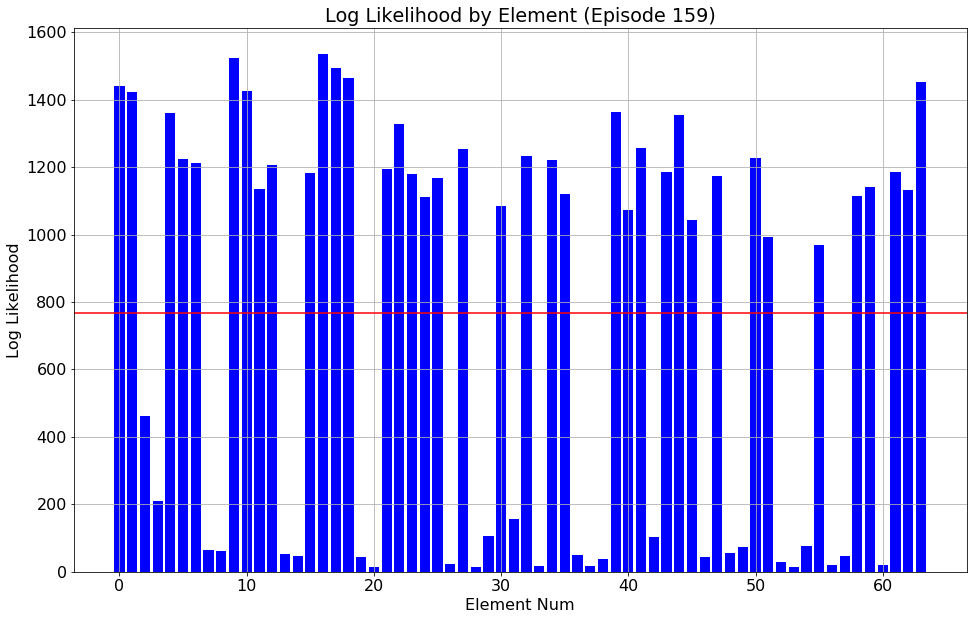

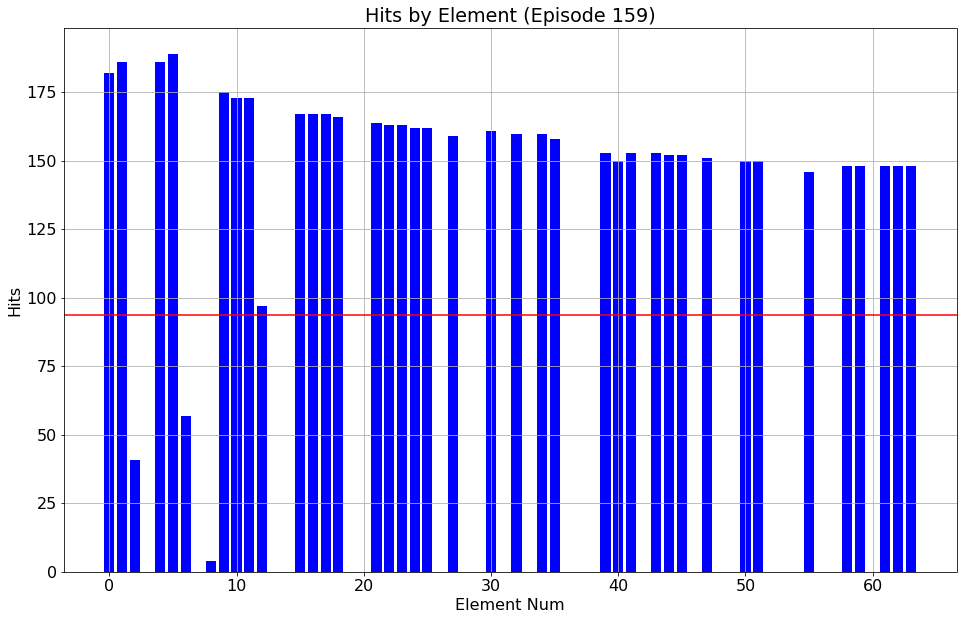


********************************************************************************
Round 2: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 159: Epoch  387, Batch  24768
effective_learning_rate=6.104e-05, training_time 1591 sec.
Train on 4096 samples
Epoch 388/391
4096/4096 [==============================] - 5s 1ms/sample - loss: inf
Adjusted element weight down on 44 candidate elements. Mean weight = 9.38e-02
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resolution:     19.55 :   176.61 :     4.77 arc seconds
Geom Mean Threshold :    774.57 :  2325.59 :   382.82 arc seconds
Mean Log Likelihood :    766.54 :    56.22 :  1221.87
Mean Hits           :     93.76 :     0.16 :   153.76
Good Elements       :     39.00

Training episode 160: Epoch  388, Batch  24832
effective_learning_rate=1.431e-06, training_time 1

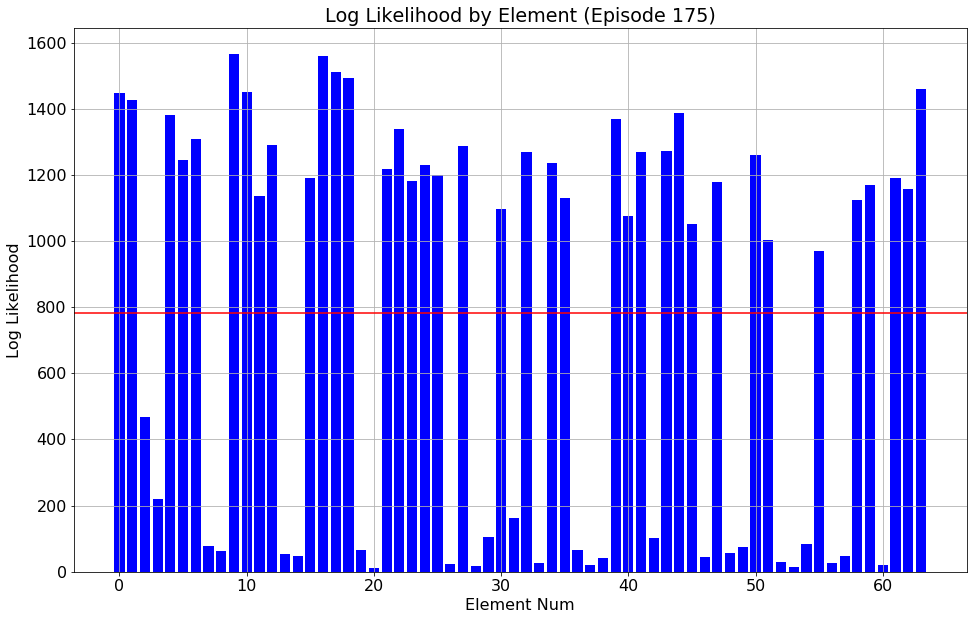

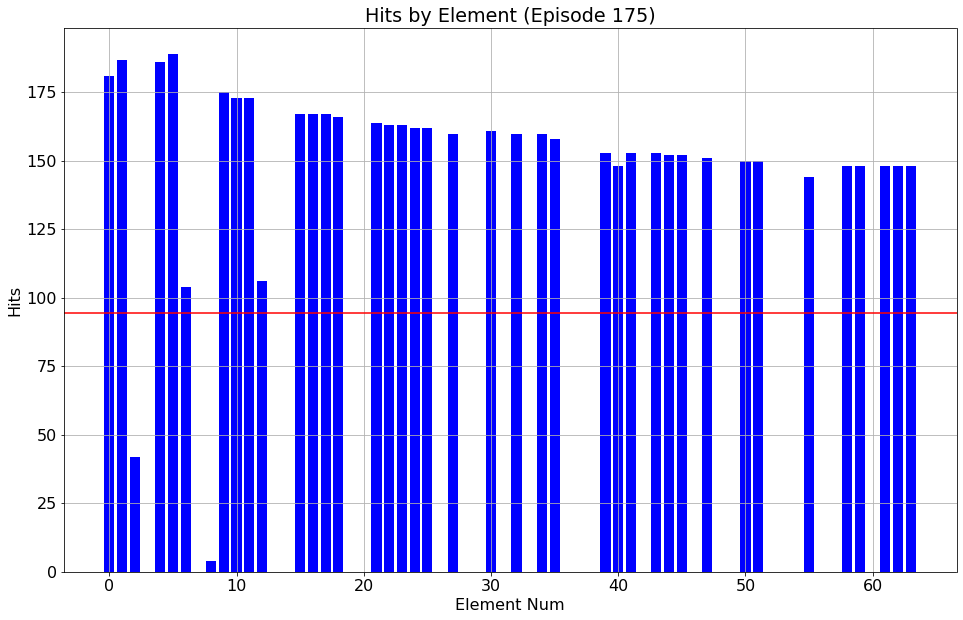


********************************************************************************
Round 3: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 5400.0
********************************************************************************
Applying learning_rate 2.44e-04 (2.0^-12.0) for adaptive training.

Training episode 175: Epoch  417, Batch  26688
effective_learning_rate=2.441e-04, training_time 1678 sec.
Train on 4096 samples
Epoch 418/421
4096/4096 [==============================] - 3s 821us/sample - loss: -1153074684928.0000
Epoch 419/421
4096/4096 [==============================] - 2s 437us/sample - loss: -1465732458496.0000
Epoch 420/421
4096/4096 [==============================] - 2s 436us/sample - loss: -1904760379392.0000
Epoch 421/421
4096/4096 [==============================] - 2s 420us/sample - loss: -2530458388480.0000
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resoluti

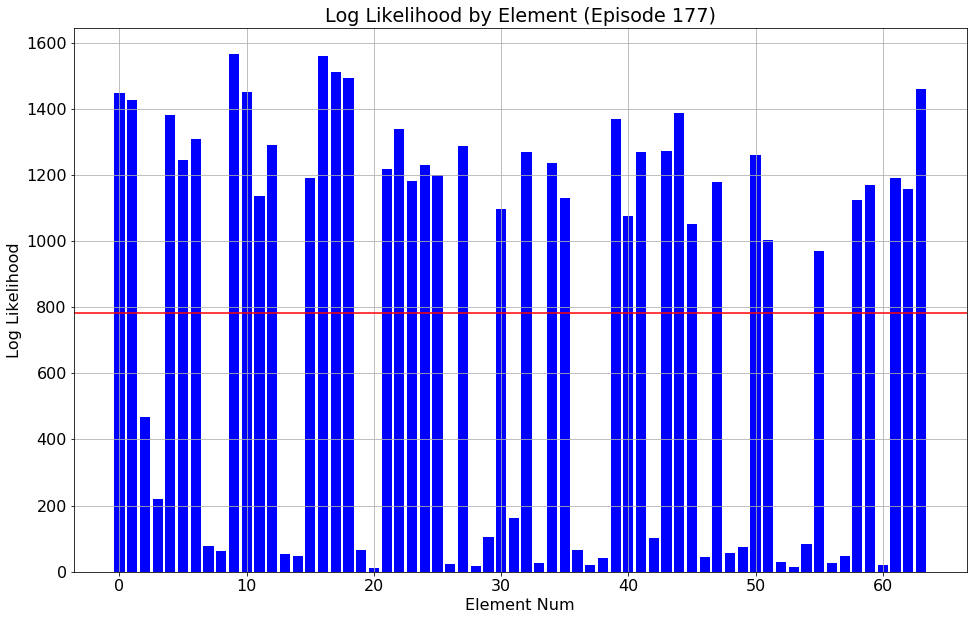

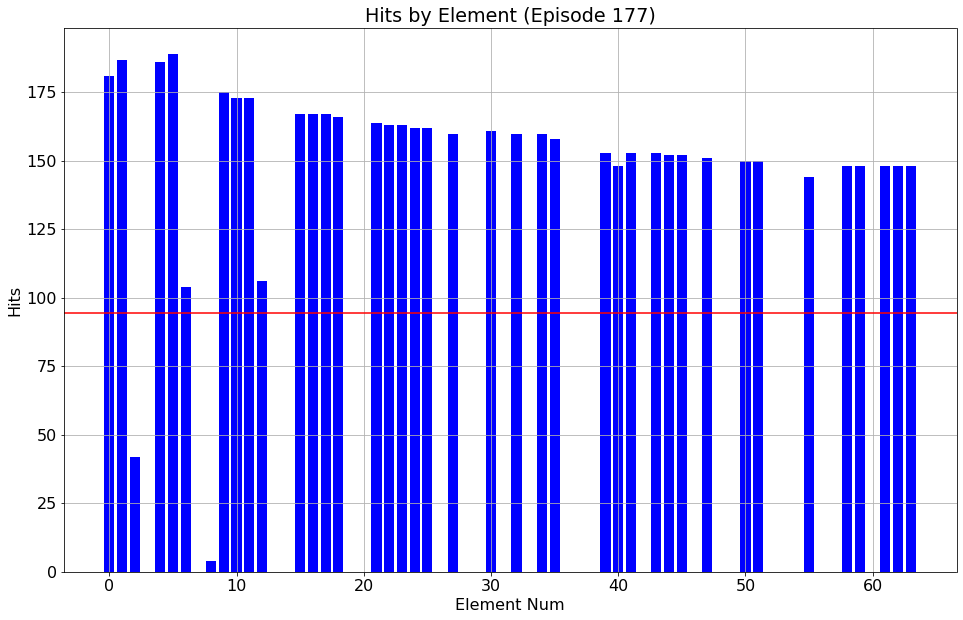


********************************************************************************
Round 4: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 177: Epoch  425, Batch  27200
effective_learning_rate=6.104e-05, training_time 1697 sec.
Train on 4096 samples
Epoch 426/429
4096/4096 [==============================] - 4s 1ms/sample - loss: inf
Adjusted element weight down on 55 candidate elements. Mean weight = 9.18e-03
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resolution:     19.46 :   178.48 :     4.70 arc seconds
Geom Mean Threshold :    806.13 :  2525.47 :   387.70 arc seconds
Mean Log Likelihood :    782.96 :    60.45 :  1246.10
Mean Hits           :     94.47 :     0.16 :   154.92
Good Elements       :     39.00

Training episode 178: Epoch  426, Batch  27264
effective_learning_rate=1.400e-07, training_time 1

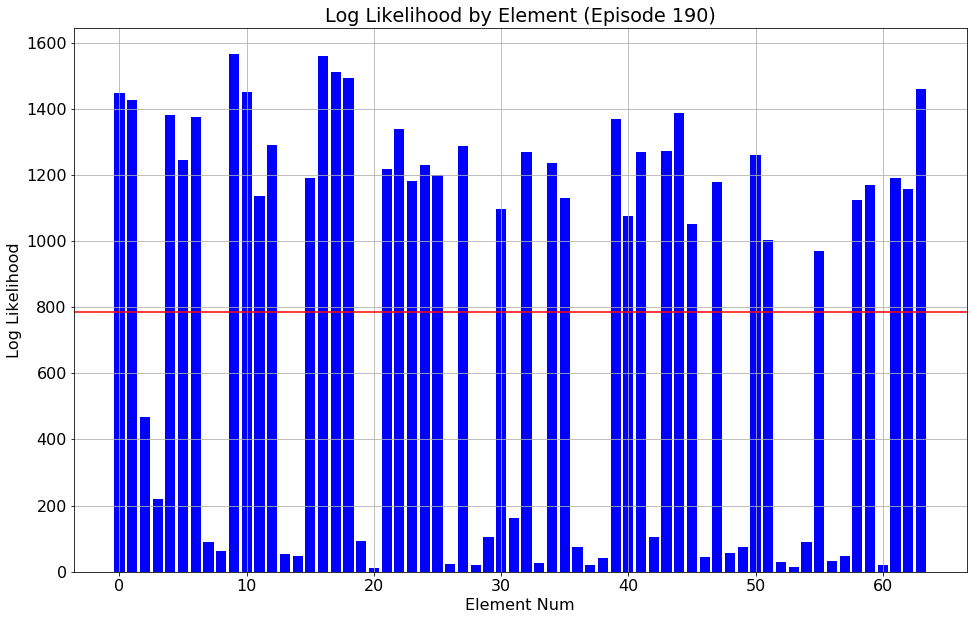

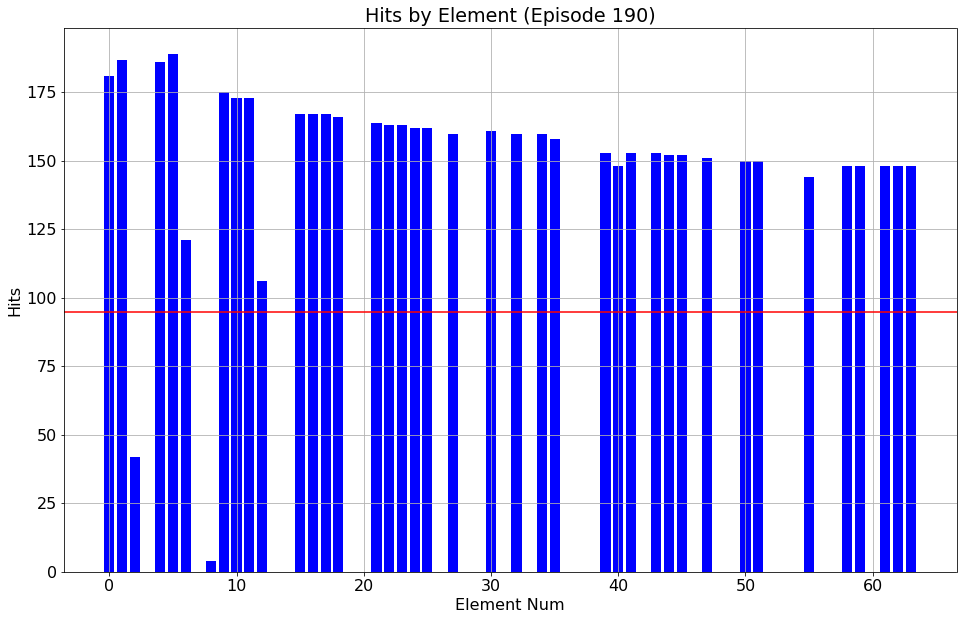


********************************************************************************
Round 5: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 3600.0
********************************************************************************
Applying learning_rate 2.44e-04 (2.0^-12.0) for adaptive training.

Training episode 190: Epoch  447, Batch  28608
effective_learning_rate=2.441e-04, training_time 1769 sec.
Train on 4096 samples
Epoch 448/451
4096/4096 [==============================] - 4s 1000us/sample - loss: -1145826373632.0000
Epoch 449/451
4096/4096 [==============================] - 2s 511us/sample - loss: -1435928727552.0000
Epoch 450/451
4096/4096 [==============================] - 2s 521us/sample - loss: -1835030380544.0000
Epoch 451/451
4096/4096 [==============================] - 2s 515us/sample - loss: -2392513411072.0000
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resolut

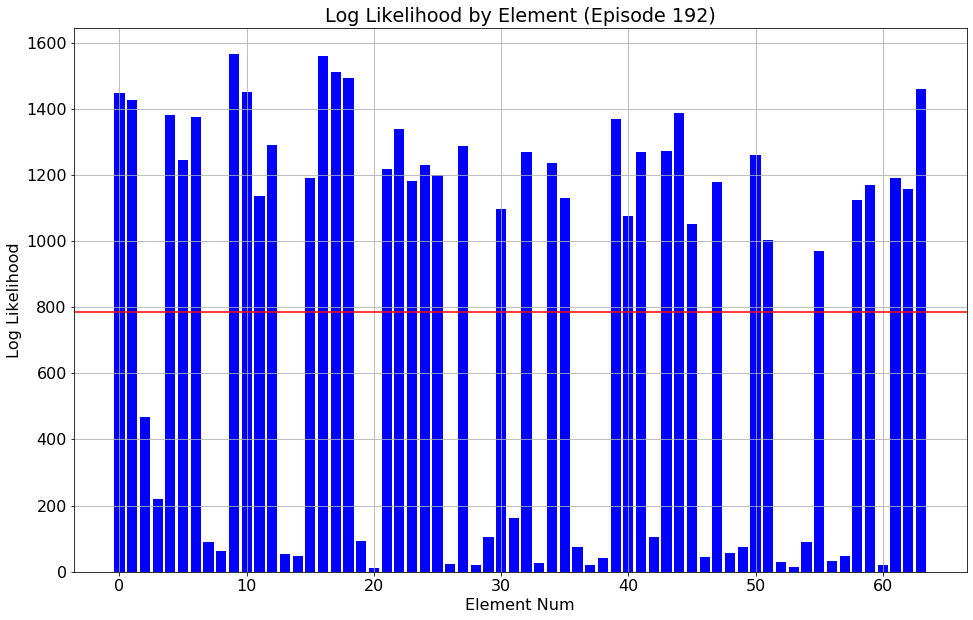

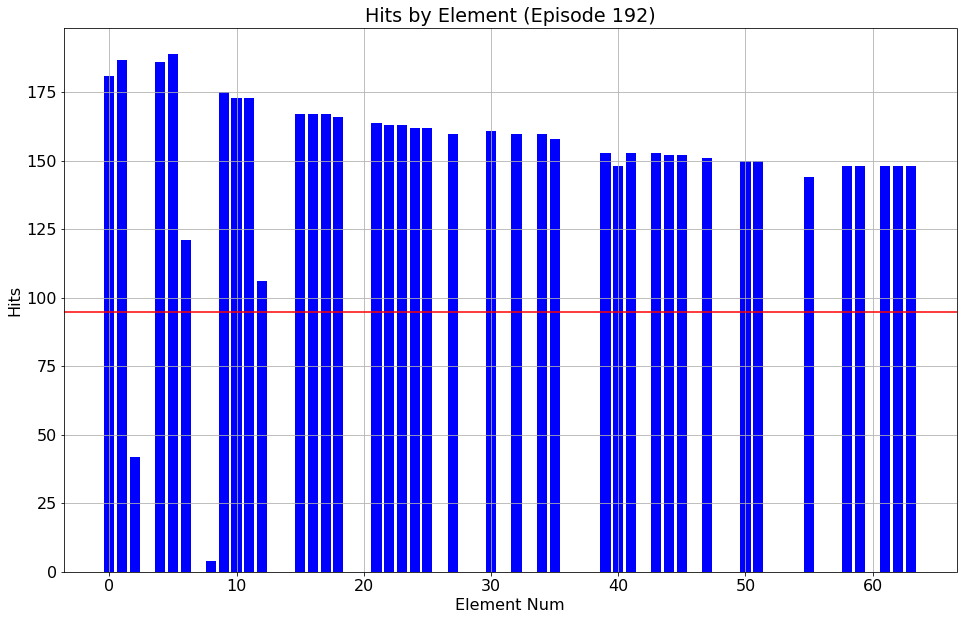


********************************************************************************
Round 6: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 192: Epoch  455, Batch  29120
effective_learning_rate=6.104e-05, training_time 1791 sec.
Train on 4096 samples
Epoch 456/459
4096/4096 [==============================] - 5s 1ms/sample - loss: inf
Adjusted element weight down on 59 candidate elements. Mean weight = 2.98e-03
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resolution:     19.45 :   179.24 :     4.68 arc seconds
Geom Mean Threshold :    819.15 :  2617.84 :   388.97 arc seconds
Mean Log Likelihood :    785.16 :    63.36 :  1247.85
Mean Hits           :     94.73 :     0.16 :   155.35
Good Elements       :     39.00

********************************************************************************
Terminating: Eff

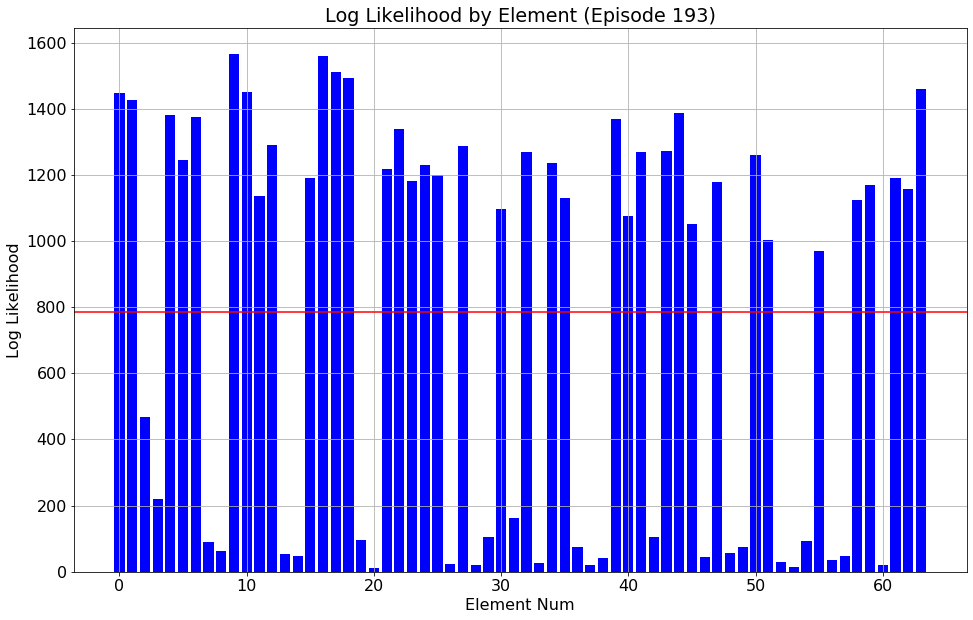

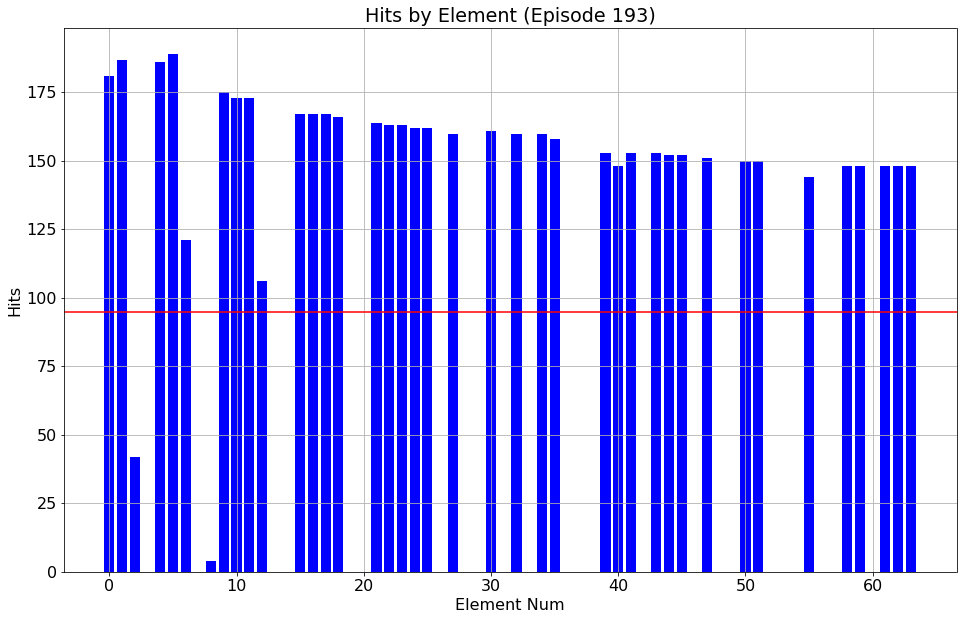


********************************************************************************
Round 7: 512 batches @ LR 2^-12 in mixture mode; thresh_sec_max = 2400.0
********************************************************************************
Applying learning_rate 2.44e-04 (2.0^-12.0) for adaptive training.

Training episode 193: Epoch  456, Batch  29184
effective_learning_rate=2.441e-04, training_time 1799 sec.
Train on 4096 samples
Epoch 457/460
4096/4096 [==============================] - 5s 1ms/sample - loss: -1138375928832.0000
Epoch 458/460
4096/4096 [==============================] - 2s 510us/sample - loss: -1406585378816.0000
Epoch 459/460
4096/4096 [==============================] - 2s 529us/sample - loss: -1768073525248.0000
Epoch 460/460
4096/4096 [==============================] - 2s 520us/sample - loss: -2262930677760.0000
Adjusted element weight down on 42 candidate elements. Mean weight = 6.72e-01
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resolution

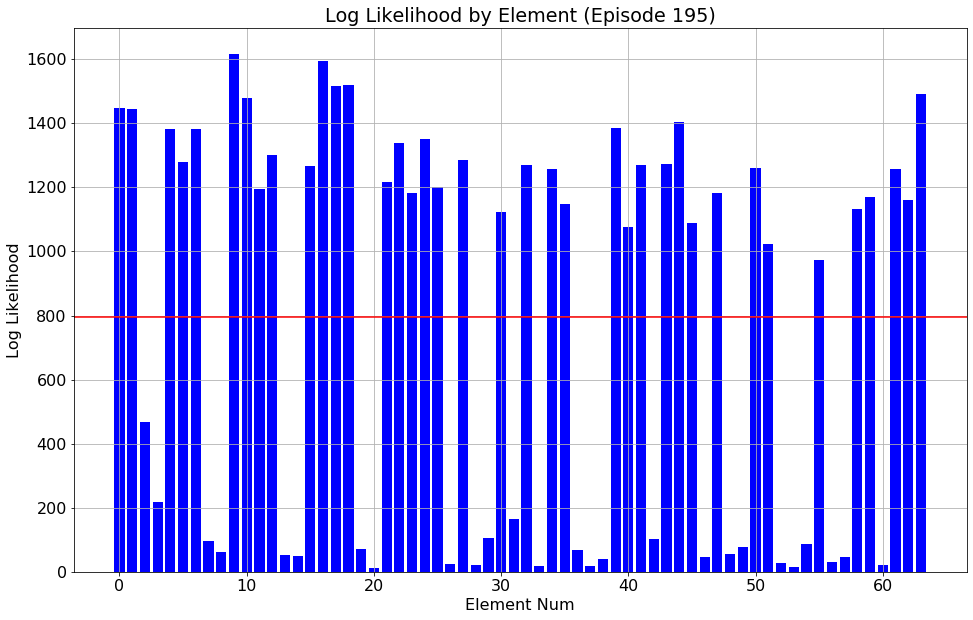

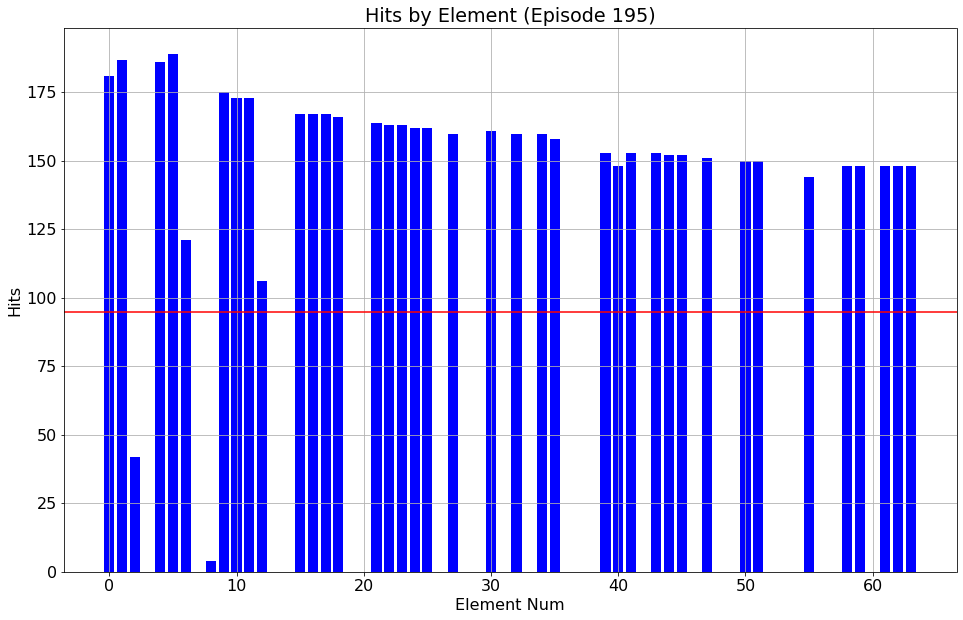


********************************************************************************
Round 8: 2048 batches @ LR 2^-16 in joint mode.
********************************************************************************
Applying learning_rate 1.53e-05 (2.0^-16.0) for adaptive training.

Training episode 195: Epoch  464, Batch  29696
effective_learning_rate=9.632e-05, training_time 1821 sec.
Train on 4096 samples
Epoch 465/468
4096/4096 [==============================] - 5s 1ms/sample - loss: inf
Adjusted element weight down on 43 candidate elements. Mean weight = 2.73e-03
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resolution:     15.17 :   174.08 :     3.17 arc seconds
Geom Mean Threshold :    651.18 :  2331.43 :   287.49 arc seconds
Mean Log Likelihood :    796.35 :    61.68 :  1267.30
Mean Hits           :     94.73 :     0.16 :   155.36
Good Elements       :     39.00

********************************************************************************
Terminating: Eff

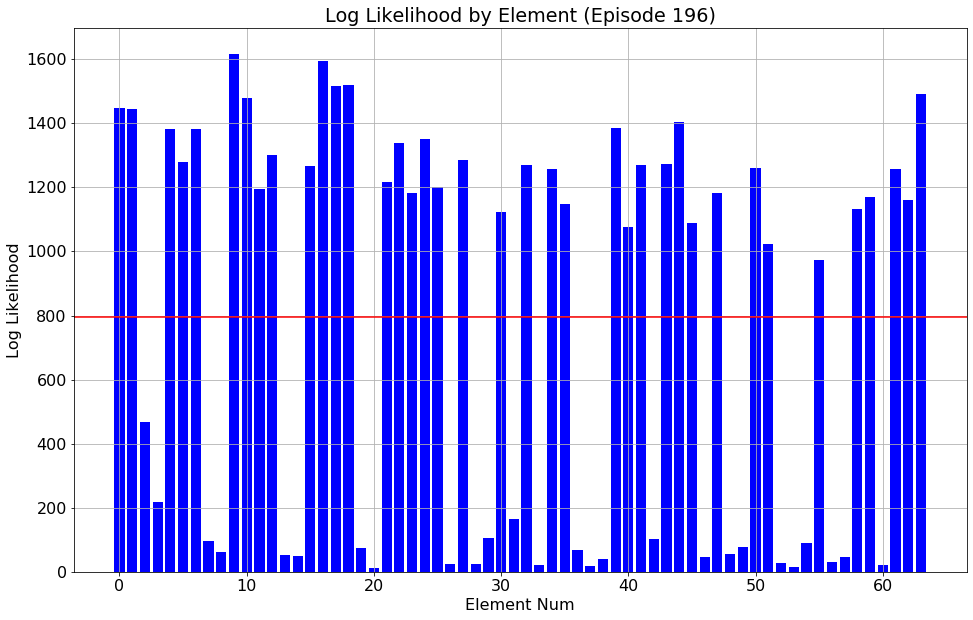

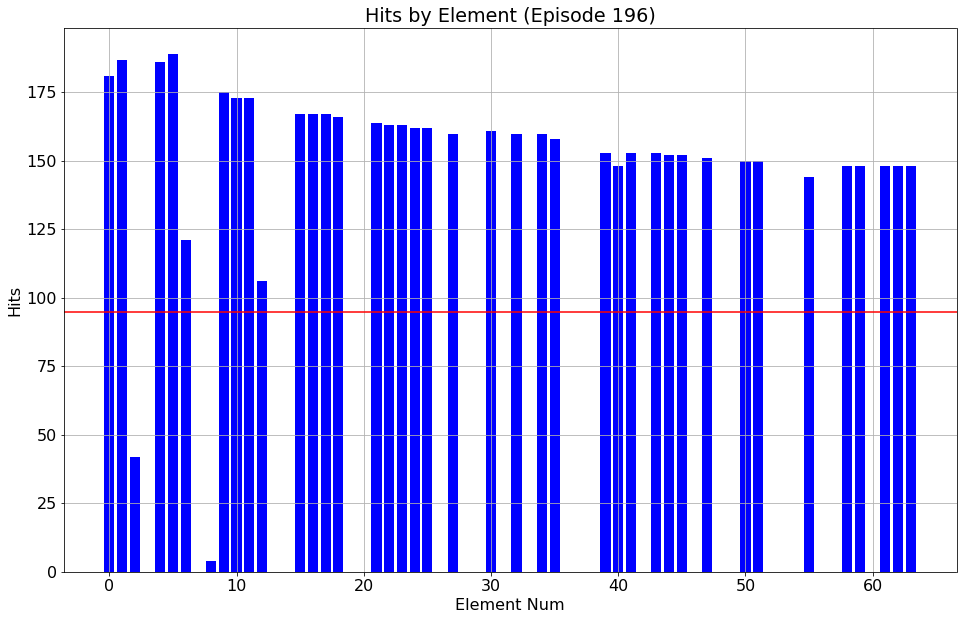


********************************************************************************
Round 5: 1024 batches @ LR 2^-13 in mixture mode.
********************************************************************************
Applying learning_rate 1.22e-04 (2.0^-13.0) for adaptive training.

Training episode 196: Epoch  465, Batch  29760
effective_learning_rate=1.221e-04, training_time 1828 sec.
Train on 4096 samples
Epoch 466/469
4096/4096 [==============================] - 4s 999us/sample - loss: -12982412514795978752.0000
Epoch 467/469
4096/4096 [==============================] - 2s 525us/sample - loss: -6340515246758690816.0000
Adjusted element weight down on 64 candidate elements. Mean weight = 5.00e-01
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resolution:     15.17 :   174.08 :     3.17 arc seconds
Geom Mean Threshold :    651.18 :  2331.43 :   287.49 arc seconds
Mean Log Likelihood :    796.35 :    61.68 :  1267.30
Mean Hits           :     94.73 :     0.16 :   1

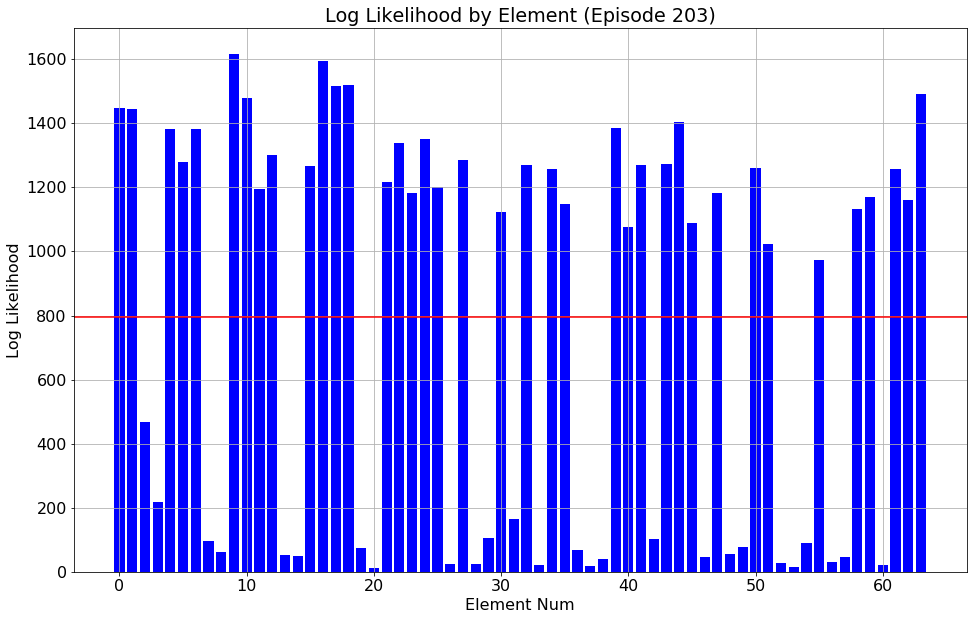

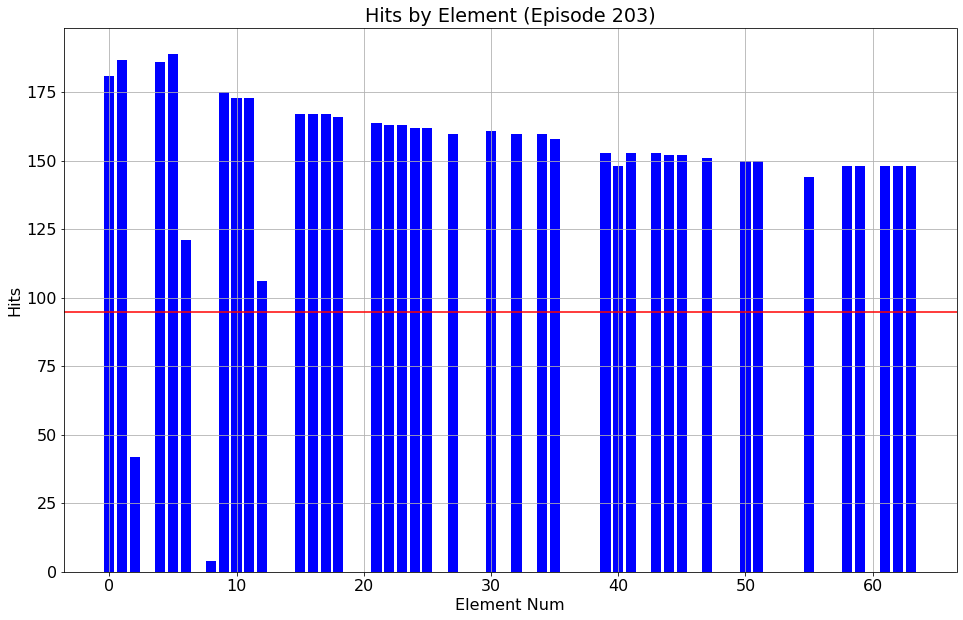


********************************************************************************
Round 6: 2048 batches @ LR 2^-18 in joint mode.
********************************************************************************

Training episode 203: Epoch  479, Batch  30656
effective_learning_rate=3.815e-06, training_time 1866 sec.
Train on 4096 samples
Epoch 480/483
4096/4096 [==============================] - 6s 1ms/sample - loss: inf
Adjusted element weight down on 40 candidate elements. Mean weight = 6.88e-01
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resolution:     15.16 :   173.84 :     3.17 arc seconds
Geom Mean Threshold :    651.10 :  2331.18 :   287.45 arc seconds
Mean Log Likelihood :    796.64 :    61.75 :  1267.73
Mean Hits           :     95.25 :     0.16 :   156.20
Good Elements       :     39.00

Training episode 204: Epoch  480, Batch  30720
effective_learning_rate=2.623e-06, training_time 1873 sec.
Train on 4096 samples
Epoch 481/484
4096/4096 [===========

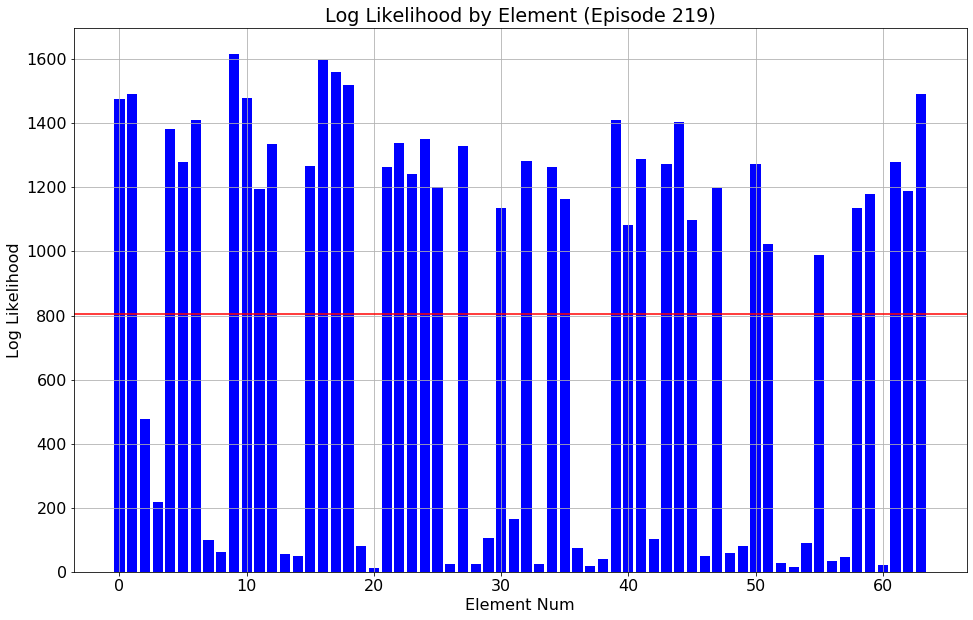

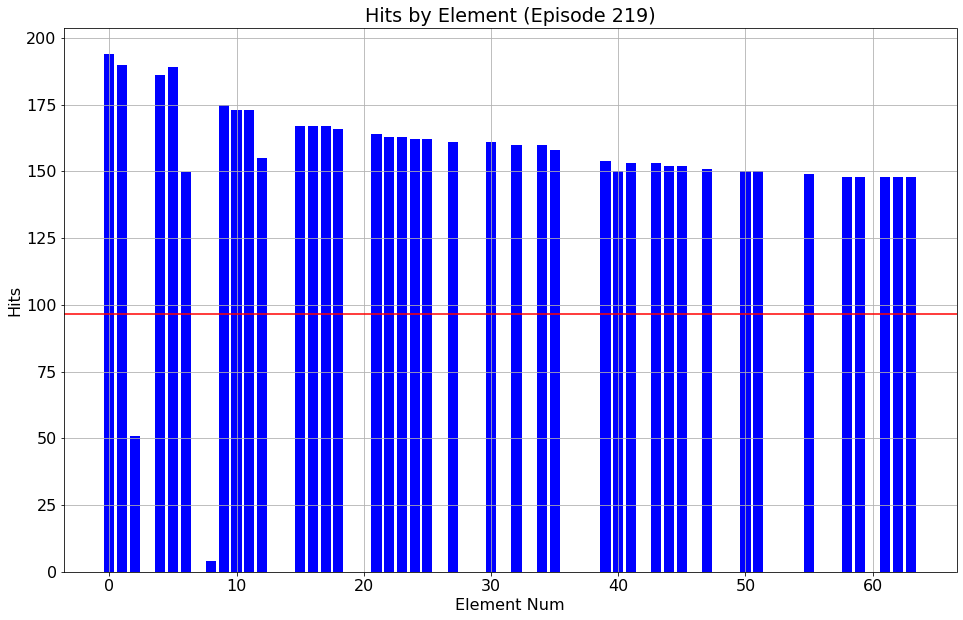


********************************************************************************
Round 7: 512 batches @ LR 2^-18 in joint mode.
********************************************************************************

Training episode 219: Epoch  511, Batch  32704
effective_learning_rate=3.815e-06, training_time 1986 sec.
Train on 4096 samples
Epoch 512/515
4096/4096 [==============================] - 6s 1ms/sample - loss: inf
Adjusted element weight down on 47 candidate elements. Mean weight = 6.33e-01
                    \  All Elts : Bad Elts : Good Elts (39)
Geom Mean Resolution:     14.71 :   167.04 :     3.10 arc seconds
Geom Mean Threshold :    643.19 :  2324.67 :   282.25 arc seconds
Mean Log Likelihood :    805.72 :    63.47 :  1281.52
Mean Hits           :     96.48 :     0.16 :   158.23
Good Elements       :     39.00

Training episode 220: Epoch  512, Batch  32768
effective_learning_rate=2.414e-06, training_time 1996 sec.
Train on 4096 samples
Epoch 513/516
4096/4096 [============

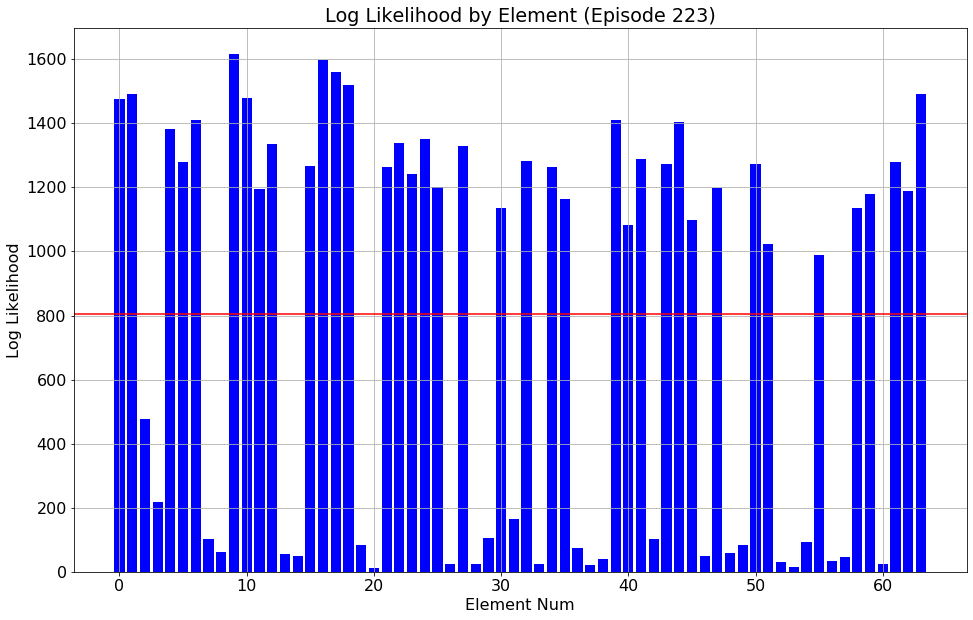

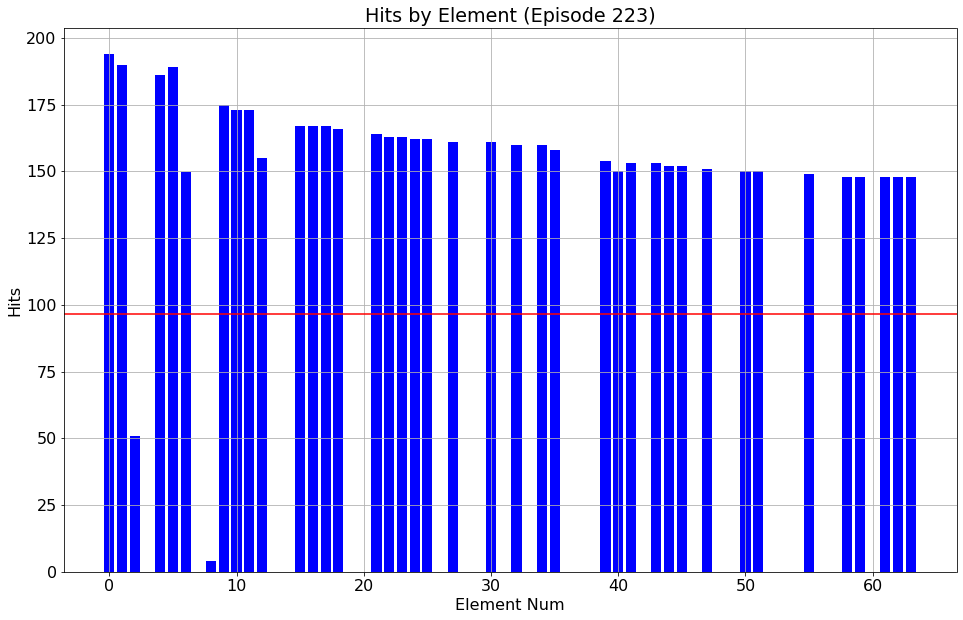

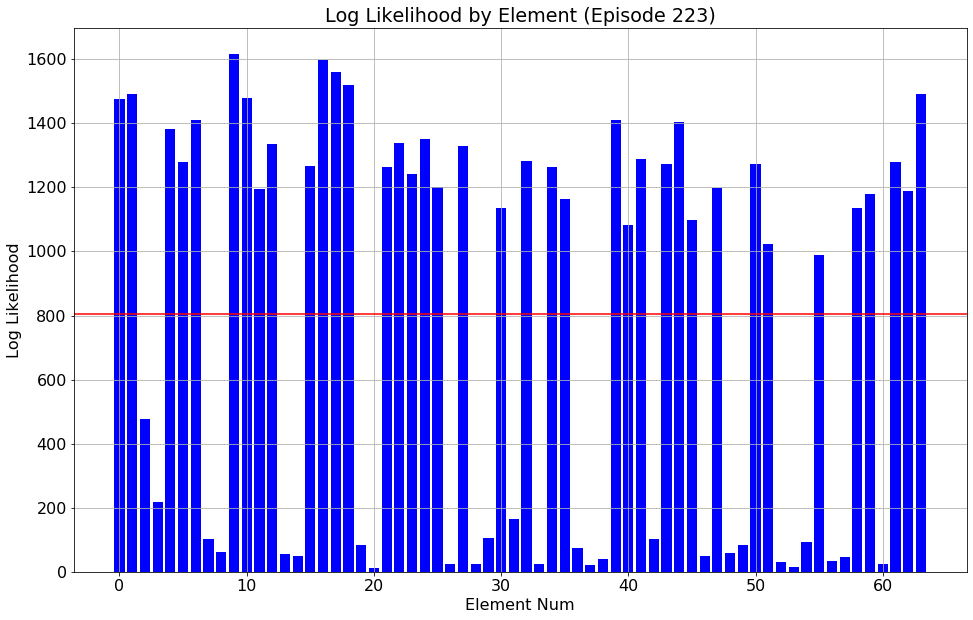

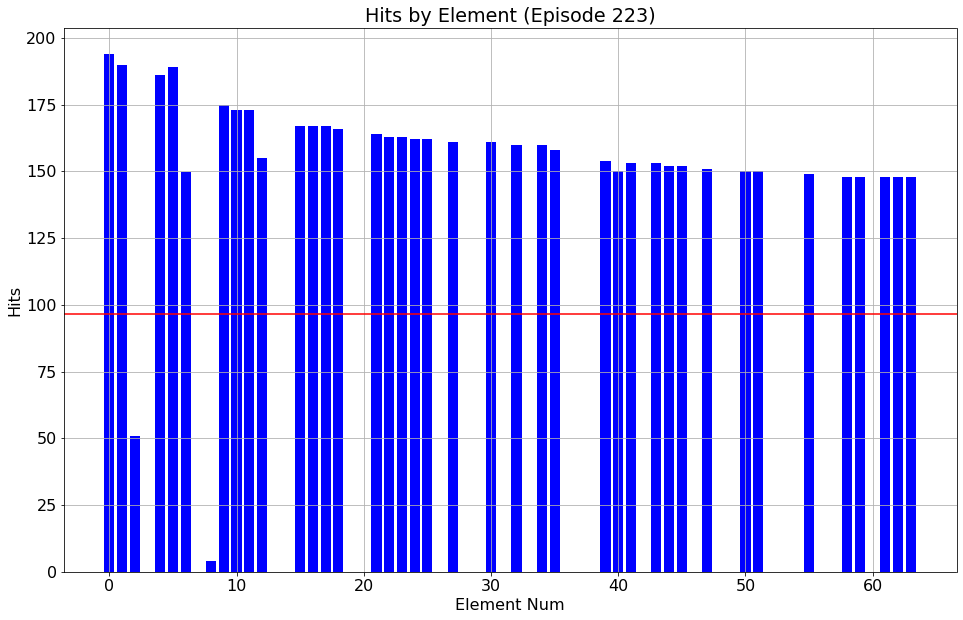

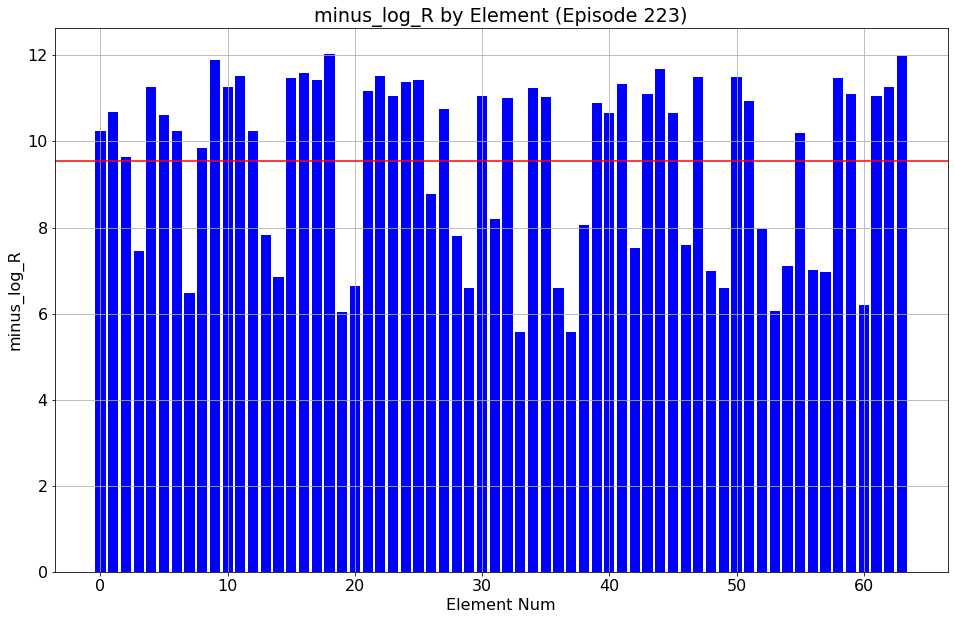

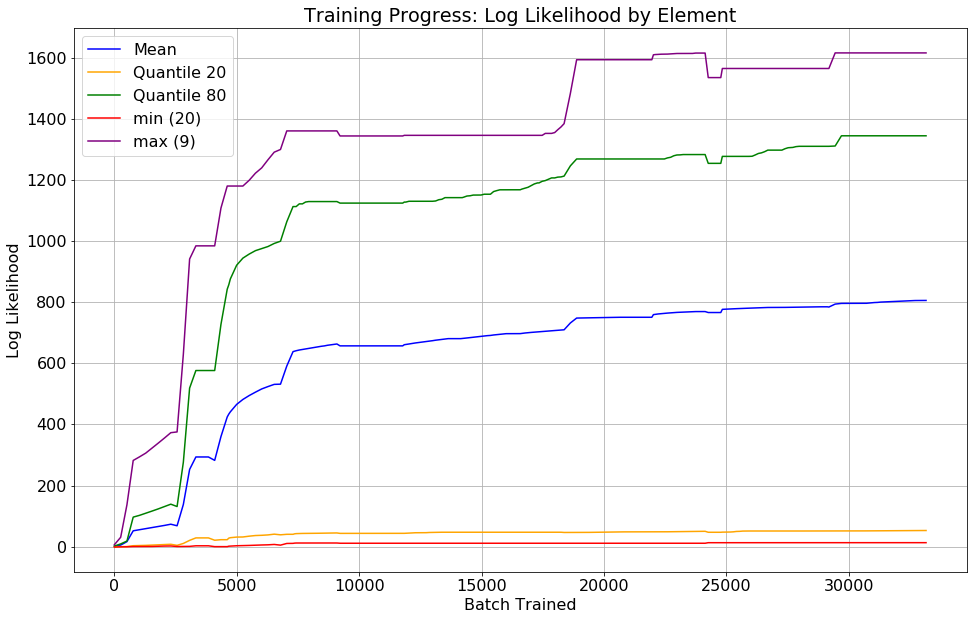

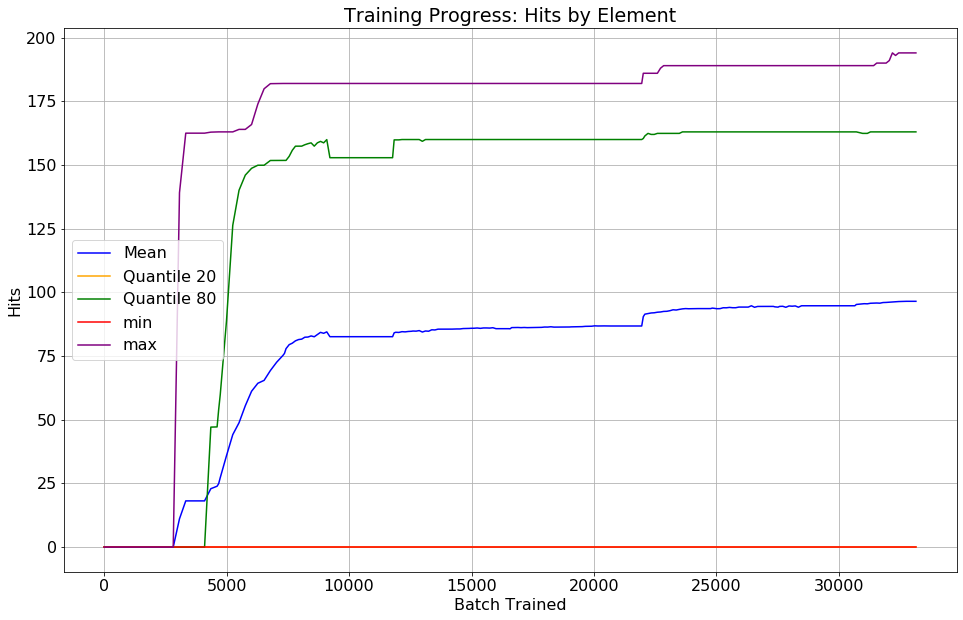

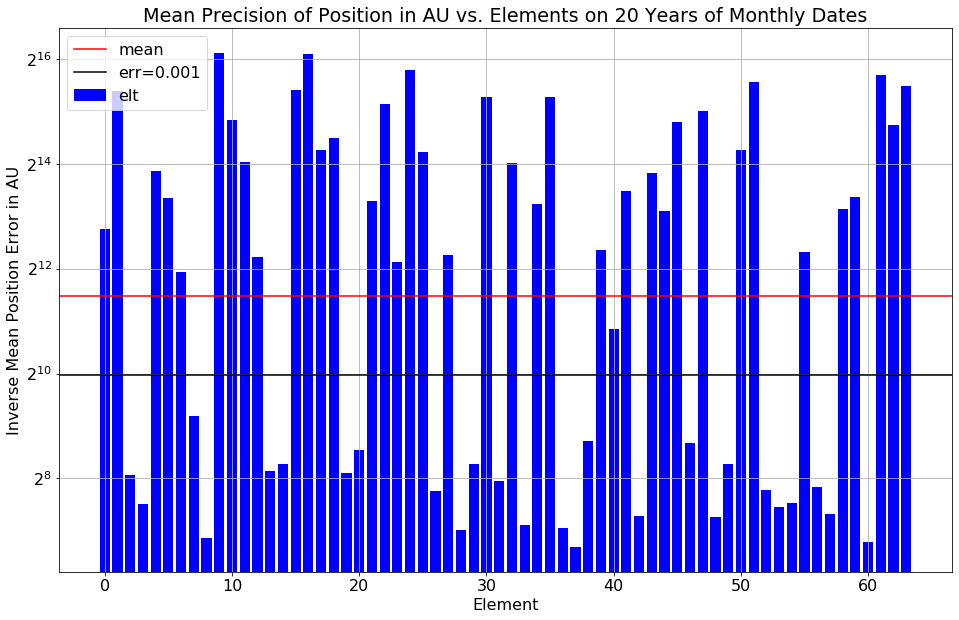

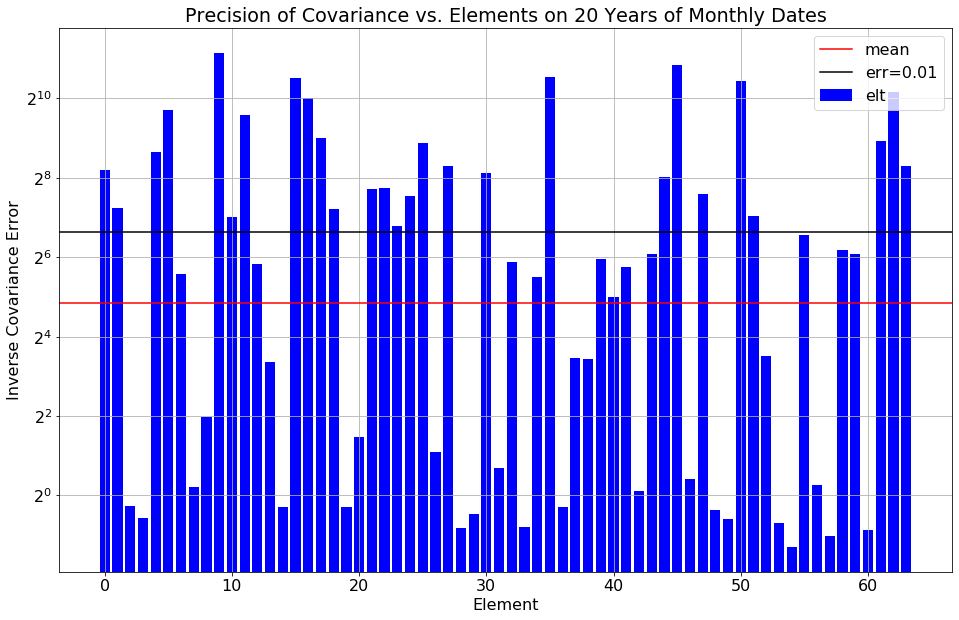

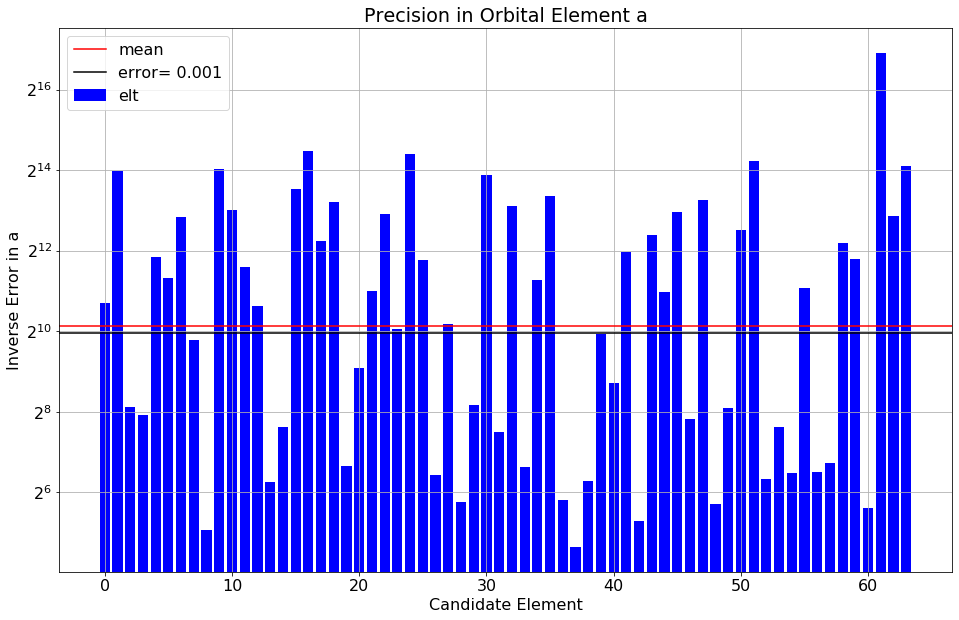

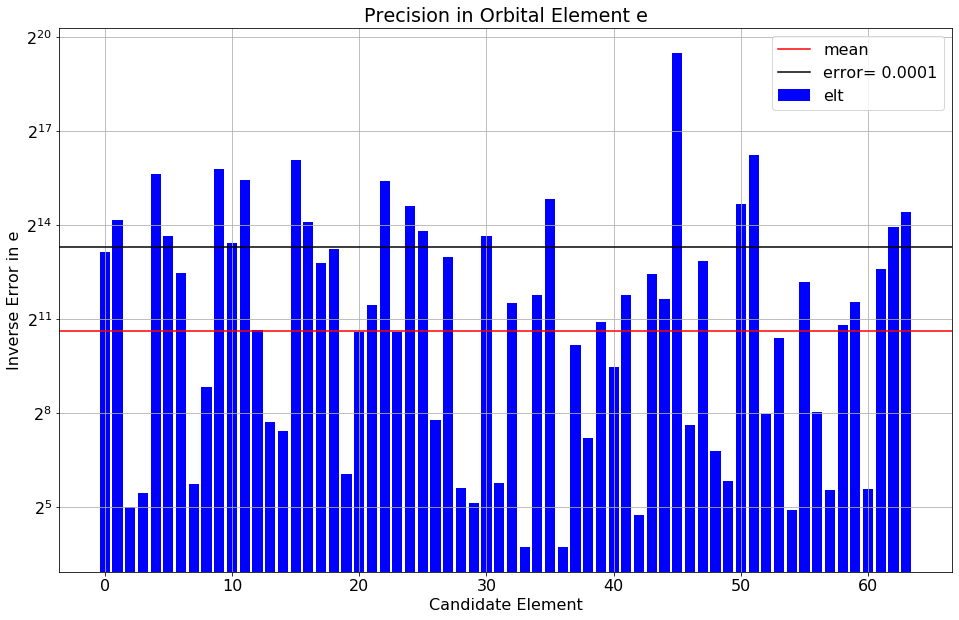

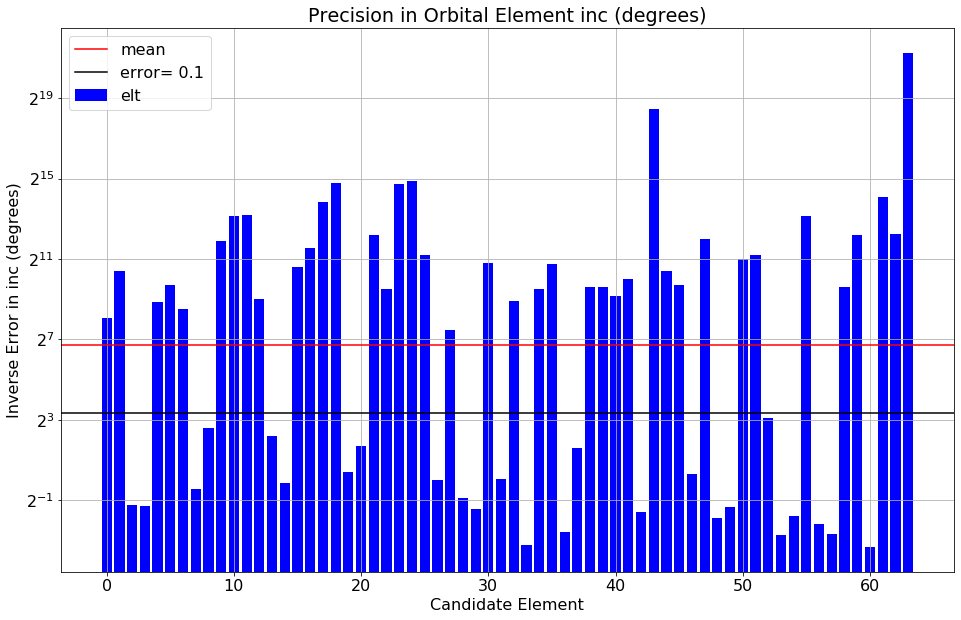

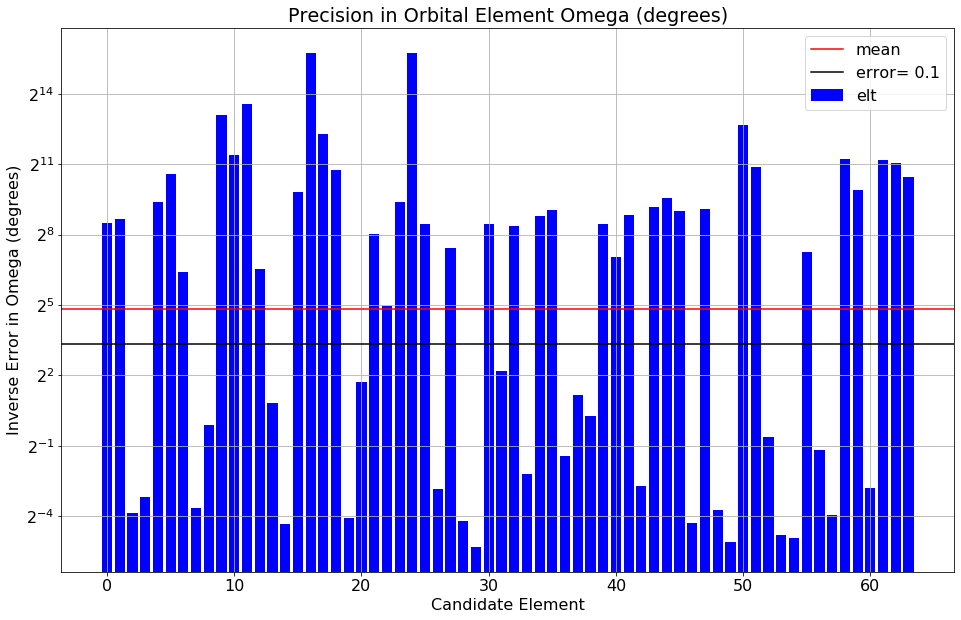

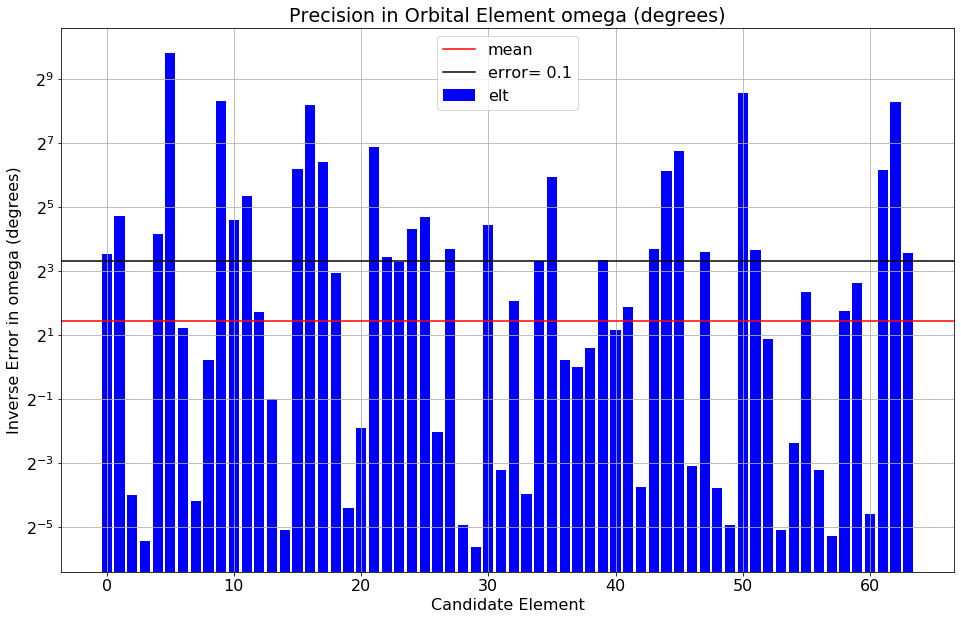

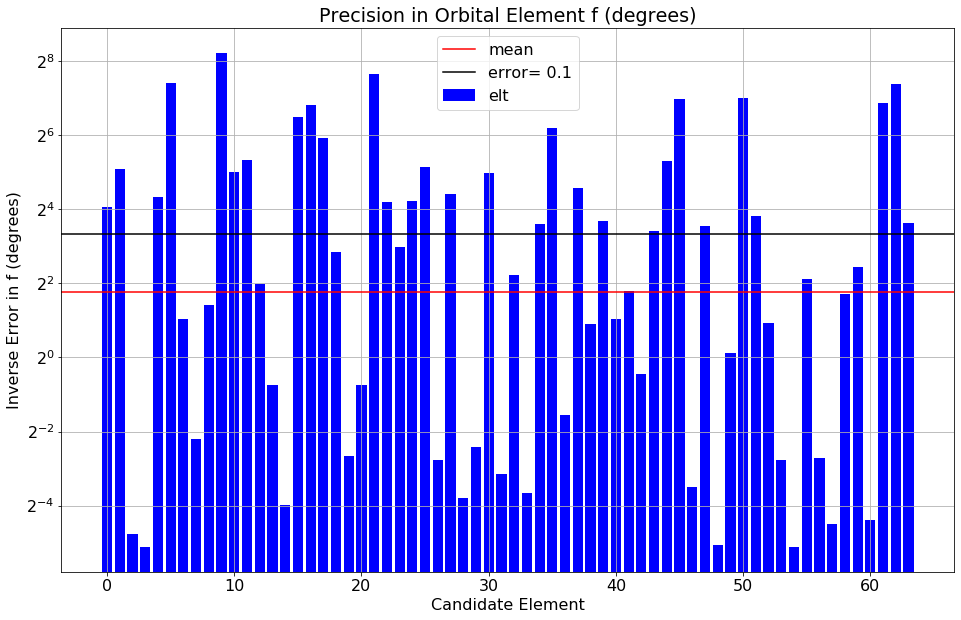

In [35]:
model.sieve()

In [36]:
model.report()


Good elements (hits >= 10):  39.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:  1281.56  : 158.23 :     3.60 :   321.08
Mean Bad :    63.95  :   0.16 :   243.73 :  2328.69
Mean     :   805.93  :  96.48 :    97.40 :  1105.30
Median   :  1149.60  : 149.50 :     4.84 :   431.96
GeoMean  :   356.34  :  21.34 :    16.66 :   643.86
Min      :    13.03  :   0.00 :     1.23 :   112.62
Max      :  1616.20  : 194.00 :   792.63 :  2400.00
Trained for 33152 batches over 518 epochs and 223 episodes (elapsed time 2020 seconds).


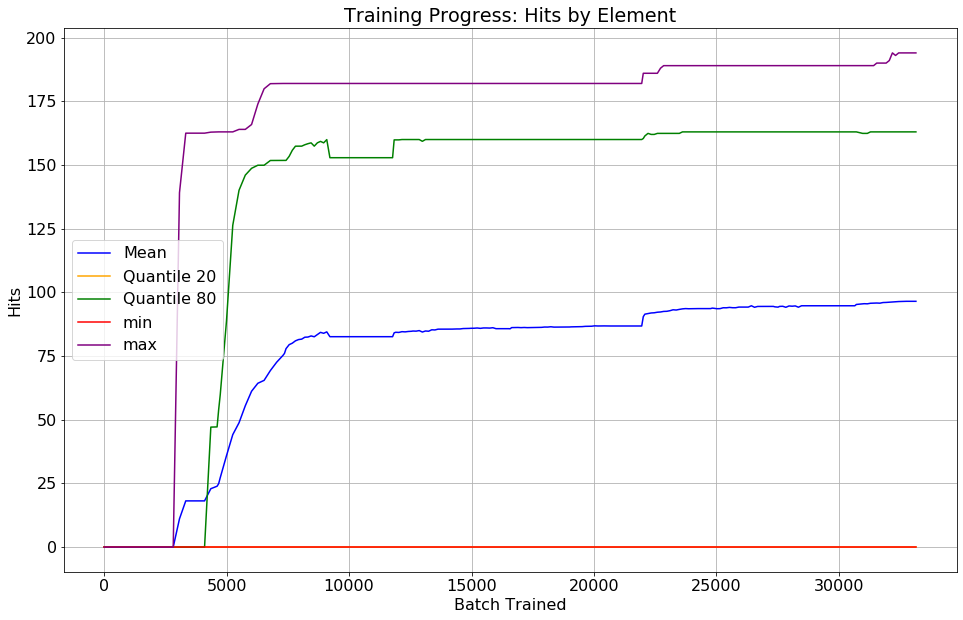

In [37]:
fig, ax = model.plot_hist('hits')

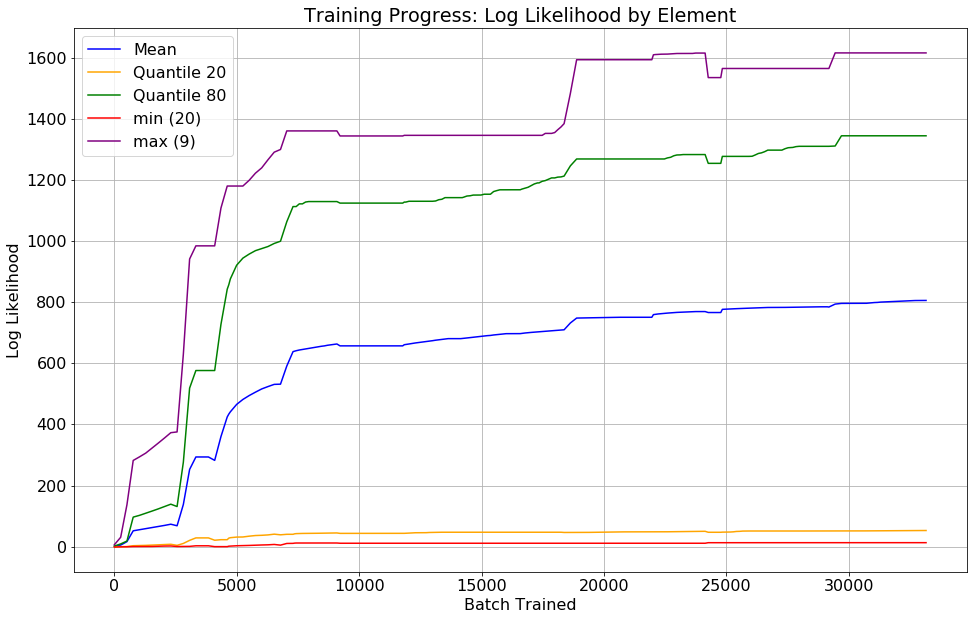

In [38]:
fig, ax = model.plot_hist('log_like')

## Distance vs. Nearest Asteroid for Fitted Elements

In [39]:
model.report()


Good elements (hits >= 10):  39.00

         \  log_like :  hits  :    R_sec : thresh_sec
Mean Good:  1281.56  : 158.23 :     3.60 :   321.08
Mean Bad :    63.95  :   0.16 :   243.73 :  2328.69
Mean     :   805.93  :  96.48 :    97.40 :  1105.30
Median   :  1149.60  : 149.50 :     4.84 :   431.96
GeoMean  :   356.34  :  21.34 :    16.66 :   643.86
Min      :    13.03  :   0.00 :     1.23 :   112.62
Max      :  1616.20  : 194.00 :   792.63 :  2400.00
Trained for 33152 batches over 518 epochs and 223 episodes (elapsed time 2020 seconds).


In [40]:
# model.save_state()

In [41]:
# Review asteroids nearest to the fitted elements
cols = ['element_id', 'log_like', 'hits', 'R_sec', 'thresh_sec', 'nearest_ast_num', 'nearest_ast_dist', 'nearest_ast_q_norm']

# Summary
has_hits = (model.elts_fit.hits >= 10)
is_converged = has_hits
num_converged = np.sum(is_converged)

# Mean on converged
mean_hits = np.mean(model.elts_fit.hits[is_converged])
mean_R_sec = np.mean(model.elts_fit.R_sec[is_converged])
err_cart_mean = np.mean(model.elts_near_ast.nearest_ast_dist[is_converged])
err_cart_geo = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_dist[is_converged])))
err_cov_mean = np.exp(np.mean(np.log(model.elts_near_ast.nearest_ast_q_norm[is_converged])))

# Report
print(f'Good convergence on {num_converged} asteroids.')
print(f'Mean on converged asteroids:')
print(f'Number of hits         : {mean_hits:5.2f}')
print(f'Resolution in arc sec  : {mean_R_sec:5.2f}')
# print(f'Mean Distance in AU    : {err_cart_mean:5.2e}')
print(f'GeoMean Distance in AU : {err_cart_geo:5.2e}')
print(f'Covariance norm        : {err_cov_mean:5.2e}')

Good convergence on 39 asteroids.
Mean on converged asteroids:
Number of hits         : 158.23
Resolution in arc sec  :  3.60
GeoMean Distance in AU : 6.63e-05
Covariance norm        : 4.89e-03


In [42]:
# Review good matches
model.elts_fit[cols][is_converged].sort_values(by=['hits', 'R_sec'], ascending=[False, True])

,element_id,log_like,hits,R_sec,thresh_sec,nearest_ast_num,nearest_ast_dist,nearest_ast_q_norm
0,51921,1476.475098,193.992096,7.343662,514.978149,51921,0.000144,0.003412
1,59244,1491.076172,189.998795,4.684971,334.252136,59244,0.000023,0.006624
5,5817,1280.612671,188.993896,5.022077,213.169144,5817,0.000097,0.001191
4,142999,1383.109619,185.996948,2.662862,166.980606,142999,0.000067,0.002492
9,14348,1616.201416,174.999908,1.419223,238.661423,14348,0.000014,0.000441
10,43796,1479.002563,172.999390,2.638614,305.812195,43796,0.000034,0.007796
11,9936,1196.482056,172.999146,2.037739,112.624550,9936,0.000060,0.001312
15,59245,1267.813721,167.000000,2.150966,135.831772,59245,0.000023,0.000688
16,48453,1597.289185,166.999908,1.910399,339.707031,48453,0.000014,0.000967
17,53516,1559.225098,166.999313,2.229850,406.967865,53516,0.000051,0.001944


In [43]:
# # Review fitted elements including nearest asteroid
# model.elts_fit

In [44]:
# Add nearest_ast_dist column
model.elts_fit['nearest_ast_dist'] = model.elts_near_ast.nearest_ast_dist
model.elts_fit['nearest_ast_q_norm'] = model.elts_near_ast.nearest_ast_q_norm

# Filter for only the good ones
mask = (model.elts_fit.log_like > 200) & (model.elts_fit.R_sec < 40)
cols = ['element_id', 'num_hits', 'R_sec', 'thresh_sec', 'log_like', 'hits', 'nearest_ast_dist', 'nearest_ast_q_norm']
model.elts_fit[cols][mask].sort_values(by='R_sec')

,element_id,num_hits,R_sec,thresh_sec,log_like,hits,nearest_ast_dist,nearest_ast_q_norm
18,4133,165.995728,1.229990,295.345093,1520.834473,165.995850,0.000043,0.006746
63,72911,148.030716,1.288202,344.972656,1492.341797,147.999939,0.000022,0.003198
9,14348,175.003265,1.419223,238.661423,1616.201416,174.999908,0.000014,0.000441
44,62002,151.994186,1.733475,339.952057,1403.056396,151.999161,0.000115,0.003864
16,48453,167.020035,1.910399,339.707031,1597.289185,166.999908,0.000014,0.000967
22,9229,162.999969,2.030262,184.662109,1340.049561,163.000000,0.000028,0.004642
11,9936,173.000839,2.037739,112.624550,1196.482056,172.999146,0.000060,0.001312
50,6455,149.989685,2.084749,210.212601,1274.516235,149.999191,0.000051,0.000720
47,733,150.969666,2.103439,169.120667,1199.229248,150.999802,0.000030,0.005220
15,59245,167.000000,2.150966,135.831772,1267.813721,167.000000,0.000023,0.000688


In [45]:
# # Filter for incomplete convergence
# mask = (elts_fit.log_like > 200) & (elts_fit.R_sec >= 60)
# elts_fit[mask]

## Visualize Error vs. Nearest Asteroid

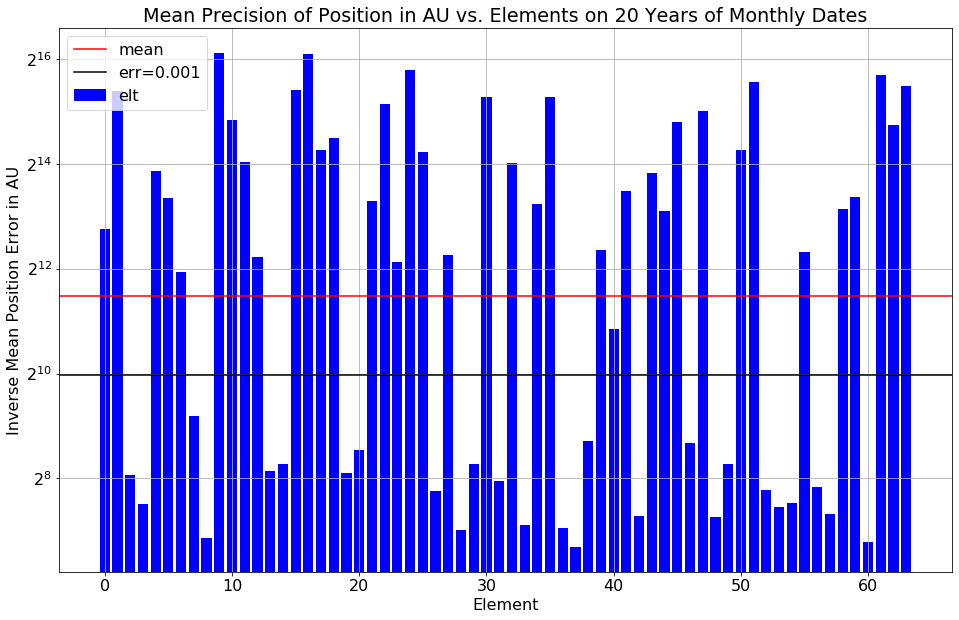

In [46]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cart', is_log=True, use_near_ast_dist=True)

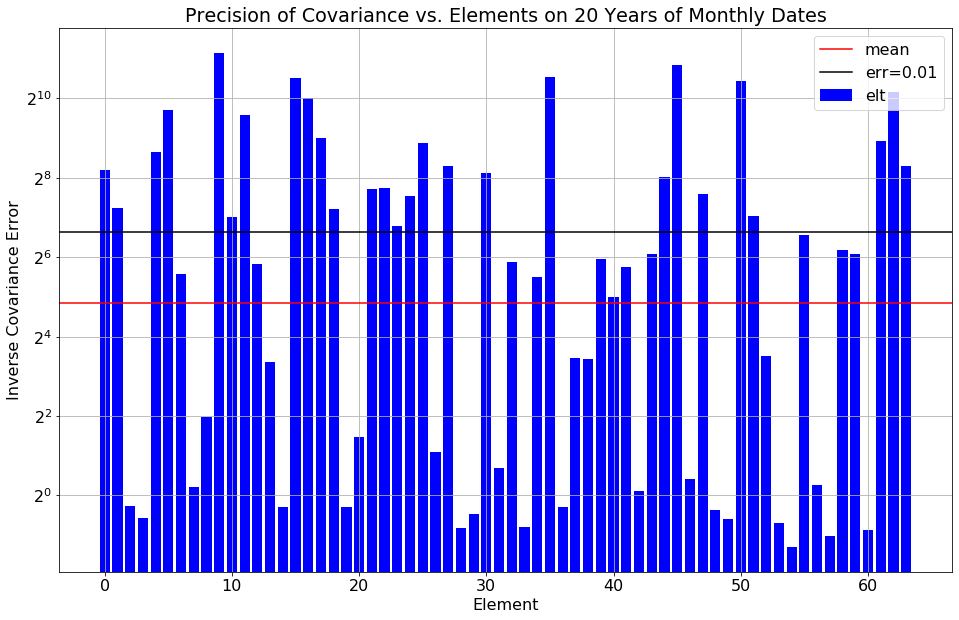

In [47]:
# Plot position error vs. known elements
fig, ax = model.plot_q_error(plot_type='cov', is_log=True, use_near_ast_dist=True)

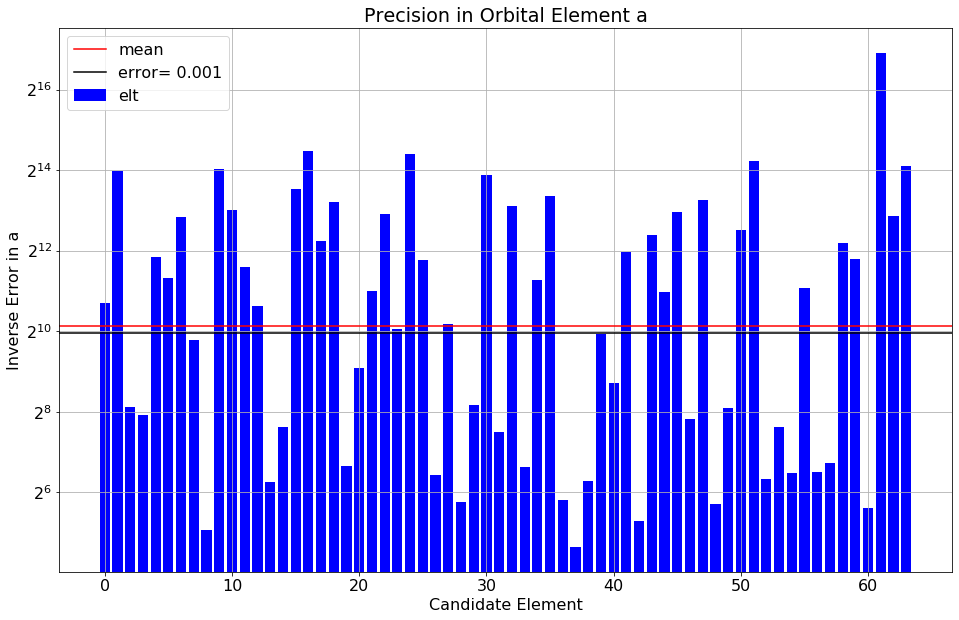

In [48]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='a', is_log=True)

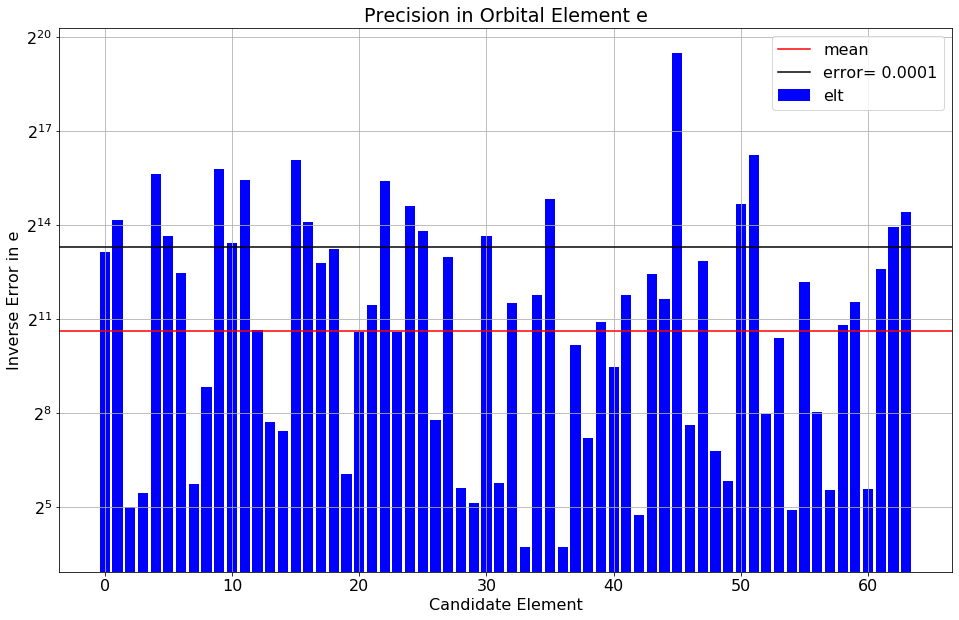

In [49]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='e', is_log=True)

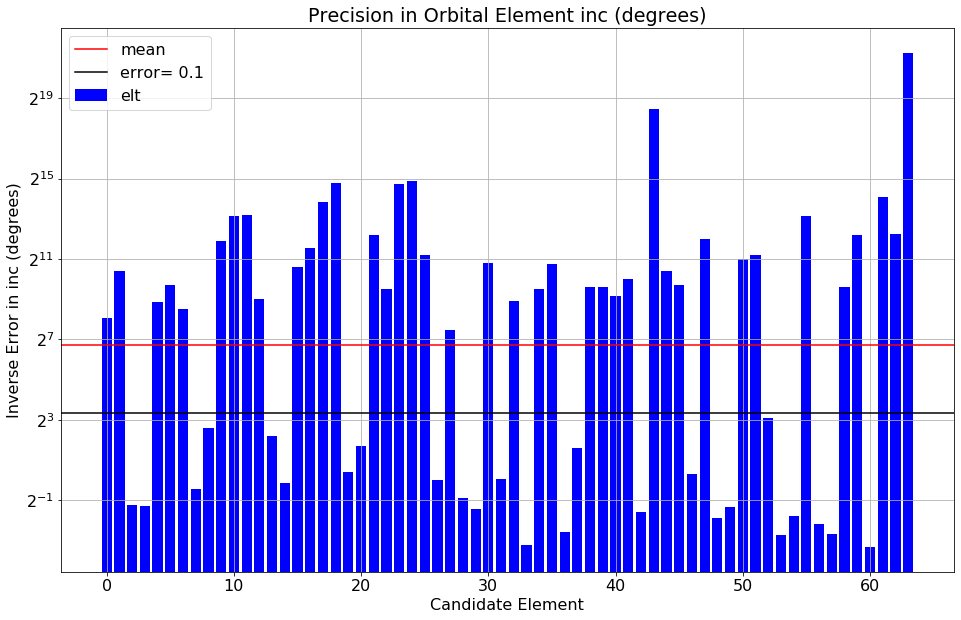

In [50]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='inc', is_log=True)

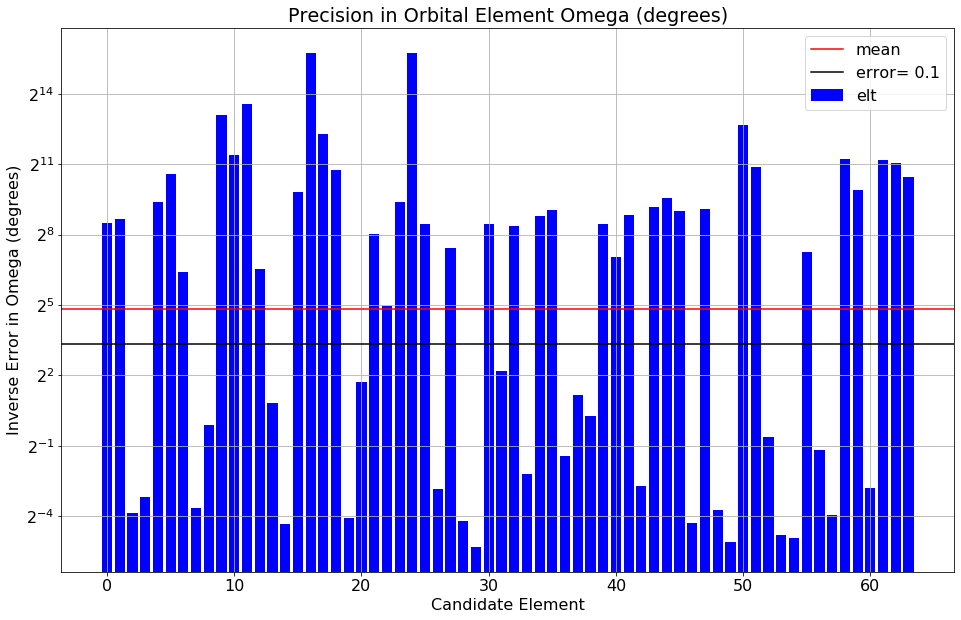

In [51]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='Omega', is_log=True)

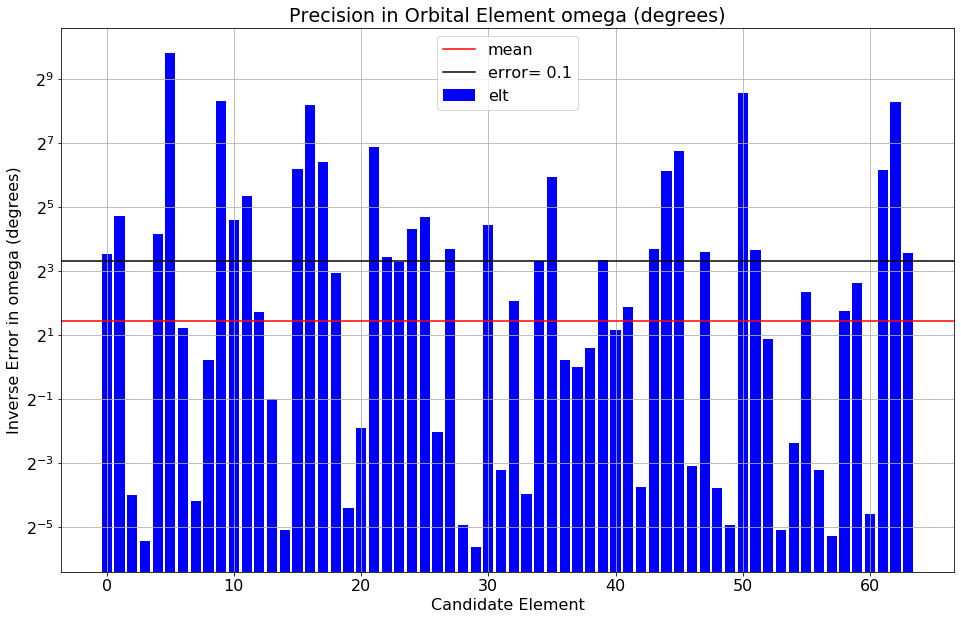

In [52]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='omega', is_log=True)

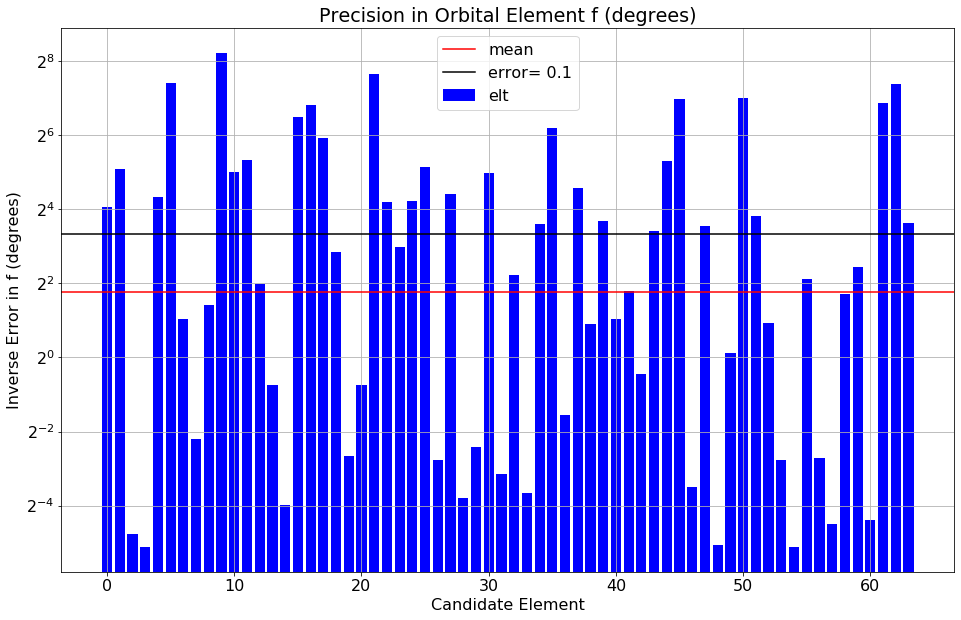

In [53]:
# Plot error in orbital elements
fig, ax = model.plot_elt_error_bar(elt_name='f', is_log=True)

In [54]:
model.get_H()

array([14.72348  , 15.243985 , 15.169971 , 18.765743 , 15.092872 ,
       15.744957 , 18.68453  , 14.982176 , 16.16015  , 17.753918 ,
       13.392243 , 17.140669 , 15.731515 , 13.082034 , 18.933619 ,
       15.143502 , 13.323375 , 18.65641  , 17.796614 , 17.992418 ,
       14.737008 , 16.342037 , 15.426258 , 17.745708 , 16.526745 ,
       15.78327  , 14.343942 , 14.785671 , 15.172945 , 14.10511  ,
       15.211078 , 12.425719 , 15.156696 , 14.901806 , 20.343084 ,
       15.810444 , 14.7373905, 15.442942 , 14.449932 , 15.617833 ,
       16.715015 , 17.340174 , 18.593235 , 13.672593 , 20.103134 ,
       15.248369 , 14.283985 , 17.209318 , 19.116228 , 14.971471 ,
       15.235578 , 15.1653185, 14.56914  , 14.677266 , 18.469515 ,
       16.104362 , 16.86203  , 18.999533 , 16.45603  , 15.250662 ,
       18.05622  , 15.035209 , 15.333809 , 17.686867 ], dtype=float32)

In [56]:
model.candidates_df()

,element_id,a,e,inc,Omega,omega,f,epoch,num_hits,R,...,thresh_deg,thresh_sec,log_like,hits,num_rows_close,H,sigma_mag,weight_joint,weight_element,weight_mixture
0,51921,2.669910,0.217471,0.499618,4.699655,2.452289,-1.134543,58600.0,193.983704,0.000036,...,0.143049,514.978149,1476.474976,193.991928,218.0,14.723480,3.914791,0.0625,1.0,0.007812
1,59244,2.634665,0.262558,0.465032,5.738255,1.767662,-1.601876,58600.0,189.978653,0.000023,...,0.092848,334.252136,1491.075928,189.998840,194.0,15.243985,3.922956,0.0625,1.0,0.007812
2,15786,1.870941,0.051806,0.386302,6.129458,0.791559,-1.252338,58600.0,89.871773,0.000066,...,0.132973,478.703400,476.758667,50.961857,137.0,15.169971,3.920396,0.0625,1.0,0.007812
3,3904,2.633205,0.096543,0.263639,5.471375,2.215273,-1.353475,58600.0,96.397888,0.000578,...,0.657104,2365.575195,218.043381,0.000000,468.0,18.765743,3.799523,0.2500,1.0,0.007812
4,142999,2.620216,0.191396,0.514055,0.238048,0.945482,-1.298432,58600.0,185.996918,0.000013,...,0.046384,166.980606,1383.109619,185.996948,190.0,15.092872,4.000000,0.0625,1.0,0.007812
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,11952,2.219932,0.086423,0.117963,0.042424,2.901997,-3.013371,58600.0,147.992462,0.000015,...,0.087233,314.040253,1177.896362,147.994537,171.0,15.250662,3.958245,0.0625,1.0,0.007812
60,134815,2.664651,0.190061,0.499571,0.235507,0.676382,-1.005612,58600.0,51.279442,0.002044,...,0.666667,2399.999756,22.808331,0.000000,492.0,18.056219,3.897527,1.0000,1.0,0.007812
61,27860,2.619414,0.096025,0.200634,5.541407,3.265802,3.948921,58600.0,147.997620,0.000016,...,0.099172,357.020966,1278.387817,147.998322,161.0,15.035209,3.939143,0.0625,1.0,0.007812
62,85937,2.342157,0.197204,0.439060,5.279685,3.210081,3.947581,58600.0,147.968613,0.000013,...,0.057045,205.361938,1188.958374,147.999069,151.0,15.333809,3.939780,0.0625,1.0,0.007812
